In [1]:
# library imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# import xgboost as xgb

# custom modules
from custom_modules import custom_plot, custom_encoder

In [2]:
class DataPreProcessor:
    '''
    Class with methods to impute, encode, and/or transform methods used to 
    pre-process data 
    '''
    def __init__(self, dataframe, target):
        self.df = dataframe # original unchanged df used for fitting encoders, etc.
        self.X  = dataframe.drop(target, axis=1)
        self.y  = dataframe[target]
        self.features  = self.X.columns
        
        # Remove rows with missing target, separate target from predictors
        missing = self.y[self.y.isnull()].index.tolist()     
        self.df.drop(missing, inplace=True)
        self.X.drop(missing, inplace=True)
        self.y.drop(missing, inplace=True)
        
        
    def log_transform_target(self):        
        self.y = np.log1p(self.y)
        self.df[self.y.name] = self.y
    
    def drop_missing(self, threshold=0.85,  X=None, verbose=False):
        '''
        Drop columns missing more than *threshold*% of its values
        @param threshold: (float)
        '''
        X = self.X if X is None else X
        
        # ------------------------------------------------------------------------------------------ #
        # For the Kaggle Housing data, some features are intended to have 'NA' as a category, 
        # so change the pd.NA for those to 'NA' where necessary
        na_allowed = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

        for feature in na_allowed:
            self.df[feature].fillna('NA', inplace=True)
            X[feature].fillna('NA', inplace=True)
            
        # ------------------------------------------------------------------------------------------ #
        # Number/proportion of missing values in each column of training data
        missing_val_count_by_column = (self.df.isnull().sum())
        missing_val_prop_by_column  = (self.df.isnull().mean())

        # Drop columns missing more than n% of values
        to_drop = missing_val_prop_by_column[missing_val_prop_by_column > threshold].index.values
        
        X.drop(to_drop, axis=1, inplace=True)
        self.features = X.columns
        if verbose: 
            print(f"TOTALS:\n{missing_val_count_by_column[missing_val_count_by_column > 0]}\n")
            print(f"PROPORTIONS:\n{missing_val_prop_by_column[missing_val_prop_by_column > 0]}\n")
            print(f"DROPPED: {to_drop}\n")
                  
    def impute(self, X=None):
        '''
        Impute missing values 
        
        @param 
        '''
        X = self.X if X is None else X
        
        for feature in self.features:
            if X[feature].dtype == "object":
                # fill categorical columns with most frequent value
                X[feature].fillna( self.df[feature].mode().iloc[0], inplace=True )
            else:
                # filling missing values with medians of the columns
                X[feature].fillna( self.df[feature].median(), inplace=True )
    
    def encode(self, encoder, args, col, X=None):
        '''
        Encode the categorical variables in the dataset using the encoder passed in
        
        @param encoder: type of encoder to use
        @param args: list of arguments used to fit & transform the column
        @return: 
        '''
        X = self.X if X is None else X
        
        encoder.fit(*args)
        X[col] = encoder.transform(X[col])
    
    def feature_engineering(self, X=None):
        '''
        dataset specific feature engineering
        '''
        X = self.X if X is None else X
        
        X['TotalBath'] = X['BsmtFullBath'] + X['FullBath'] + ((X['BsmtHalfBath']  + X['HalfBath']) / 2)
        X.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1, inplace=True)
        
        # Age = (Most Recent Yr in All Data) - (Yr House was Last Remod.)
        X['Age'] = X['YearRemodAdd'].max() - X['YearRemodAdd']
        
        X['ExterAggr'] = X['ExterQual'] + X['ExterCond']
        X.drop(['ExterQual', 'ExterCond'], axis=1, inplace=True)
        
        X['BsmtAggr'] = X['BsmtQual'] + X['BsmtCond'] + X['BsmtExposure'] + ((X['BsmtFinType1'] + X['BsmtFinType2']) / 2)
        X.drop(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], axis=1, inplace=True)
        
        X['GarageAggr'] = X['GarageFinish'] + X['GarageQual'] + X['GarageCond']
        X.drop(['GarageFinish', 'GarageQual', 'GarageCond'], axis=1, inplace=True)
        
        X['TotalSF'] = X['TotalBsmtSF'] + X['GrLivArea']
        X.drop(['TotalBsmtSF', 'GrLivArea', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
        
        self.features = X.columns
    

In [3]:
def score_dataset(X_train, X_valid, y_train, y_valid, model, err_func):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return err_func(y_valid, preds)

def score_log_dataset(X_train, X_valid, y_train, y_valid, model, err_func):
    model.fit(X_train, y_train)
    preds   = np.expm1(model.predict(X_valid))
    y_valid = np.expm1(y_valid)
    return err_func(y_valid, preds)

def feature_importances(model, columns):
    feat_imp = { columns[i]: model.feature_importances_[i] for i in range(len(columns)) }
    return dict(sorted(feat_imp.items(), key=lambda item: item[1], reverse=True))


###### Read Data

In [4]:
# Read the data
df_train = pd.read_csv('train.csv', index_col="Id")
df_test = pd.read_csv('test.csv', index_col="Id")

###### Distribution of Target

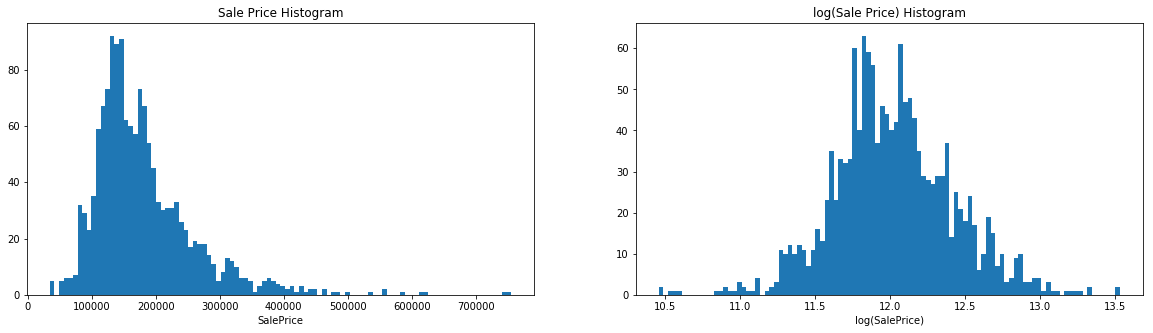

In [5]:
# Sale Price Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.hist(df_train.SalePrice, bins=100)
ax1.set_xlabel("SalePrice")
ax1.set_title("Sale Price Histogram")

ax2.hist(np.log1p(df_train.SalePrice), bins=100)
ax2.set_xlabel("log(SalePrice)")
ax2.set_title("log(Sale Price) Histogram")

plt.show()

###### Preprocess Data

In [6]:
encoder_map = { 
    'MSSubClass': 'RankLabelEncoder',
    'MSZoning': 'RankLabelEncoder',
    'Street': 'RankLabelEncoder',
    'Alley': 'RankLabelEncoder',
    'LotShape': 'custom',
    'LandContour': 'RankLabelEncoder',
    'Utilities': 'custom',
    'LotConfig': 'RankLabelEncoder',
    'LandSlope': 'RankLabelEncoder',
    'Neighborhood': 'RankLabelEncoder',
    'Condition1': 'RankLabelEncoder',
    'Condition2': 'RankLabelEncoder',
    'BldgType': 'RankLabelEncoder',
    'HouseStyle': 'RankLabelEncoder',
    'RoofStyle': 'RankLabelEncoder',
    'RoofMatl': 'RankLabelEncoder',
    'Exterior1st': 'RankLabelEncoder',
    'Exterior2nd': 'RankLabelEncoder',
    'MasVnrType': 'RankLabelEncoder',
    'ExterQual': 'custom',
    'ExterCond': 'custom',
    'Foundation': 'RankLabelEncoder',
    'BsmtQual': 'custom',
    'BsmtCond': 'custom',
    'BsmtExposure': 'custom',
    'BsmtFinType1': 'custom',
    'BsmtFinType2': 'custom',
    'Heating': 'RankLabelEncoder',
    'HeatingQC': 'custom',
    'CentralAir': 'custom',
    'Electrical': 'custom',
    'KitchenQual': 'custom',
    'Functional': 'custom',
    'FireplaceQu': 'custom',
    'GarageType': 'RankLabelEncoder',
    'GarageFinish': 'custom',
    'GarageQual': 'custom',
    'GarageCond': 'custom',
    'PavedDrive': 'custom',
    'PoolQC': 'custom',
    'Fence': 'custom',
    'MiscFeature': 'RankLabelEncoder',
    'SaleType': 'RankLabelEncoder',
    'SaleCondition': 'RankLabelEncoder',
}

# order for features where the order can be inferred by the categories
custom_map = {
    'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3},
    'Utilities': {'AllPub': 0, 'NoSewr': 1, 'NoSeWa': 2, 'ELO': 3},
    'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'FuseP': 0, 'FuseF': 1, 'Mix': 2, 'FuseA': 3, 'SBrkr': 4},
    'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Functional': {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3,'Mod': 4, 'Min2': 5, 'Min1': 6,'Typ': 7},
    'FireplaceQu': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'NA': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Fence': {'NA': 0, 'MnWw': 1, 'MnPrv': 2, 'GdWo': 3, 'GdPrv': 4}
}

In [7]:
train = df_train.copy()
preprocess = DataPreProcessor(train, 'SalePrice')

preprocess.drop_missing(threshold=1, verbose=True)
preprocess.impute()
preprocess.log_transform_target()
# --------------------------------- Plot Data Distributions -------------------------------- #
# custom_plot.data_distribution_scatters(preprocess.X, preprocess.y)
# ------------------------------------------------------------------------------------------ #


rle = custom_encoder.RankLabelEncoder()
for col,encoder in encoder_map.items():
    if encoder == 'RankLabelEncoder':
        preprocess.encode( rle, [preprocess.df[col], preprocess.df[preprocess.y.name]], col )
    else: # == 'custom' 
        preprocess.X[col].replace( custom_map[col], inplace=True )

# preprocess.feature_engineering()
   
X, y  = preprocess.X, preprocess.y   
train = pd.concat([X, y], axis=1)

TOTALS:
LotFrontage     259
Alley          1369
MasVnrType        8
MasVnrArea        8
Electrical        1
GarageYrBlt      81
dtype: int64

PROPORTIONS:
LotFrontage    0.177397
Alley          0.937671
MasVnrType     0.005479
MasVnrArea     0.005479
Electrical     0.000685
GarageYrBlt    0.055479
dtype: float64

DROPPED: []



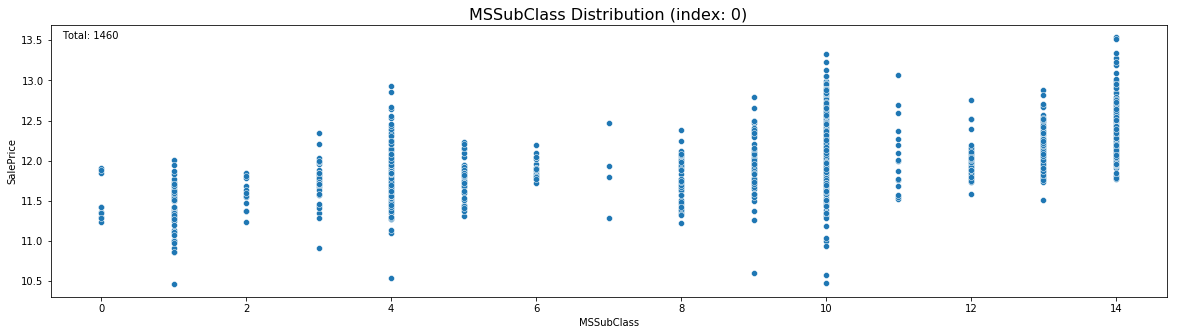

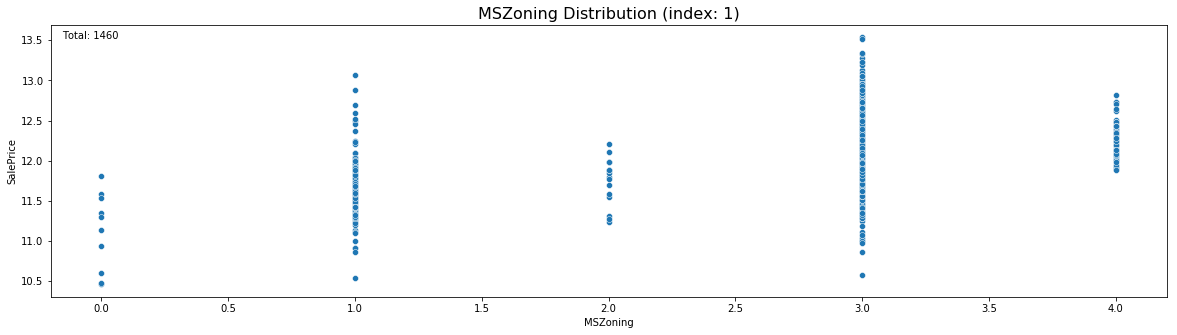

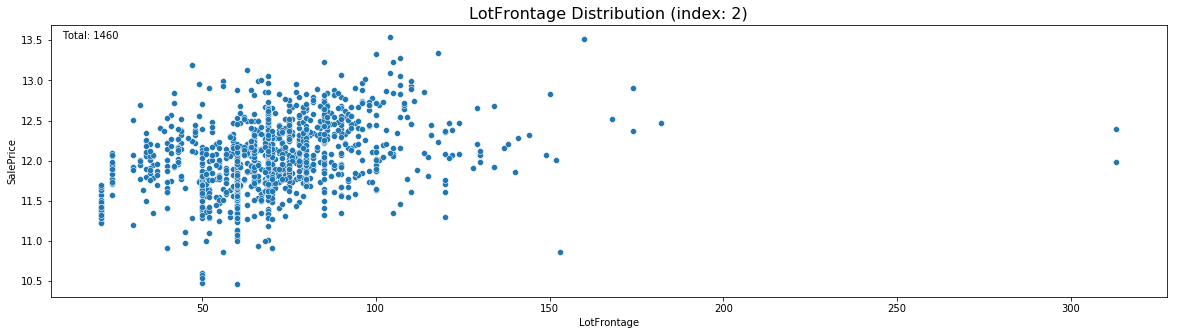

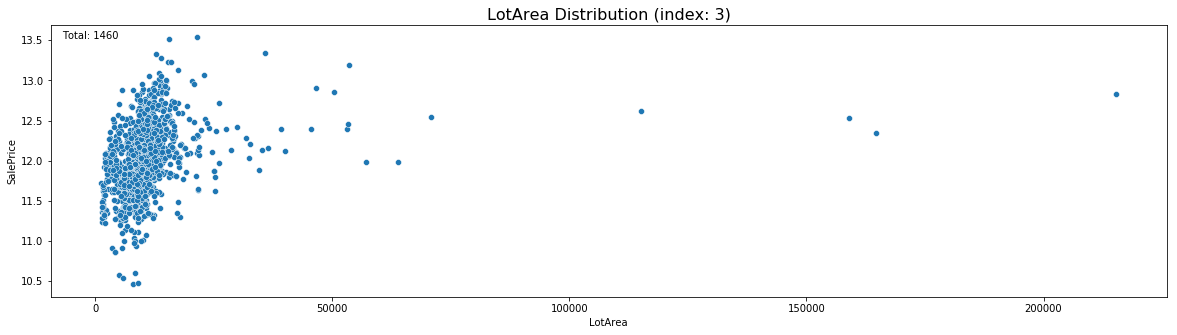

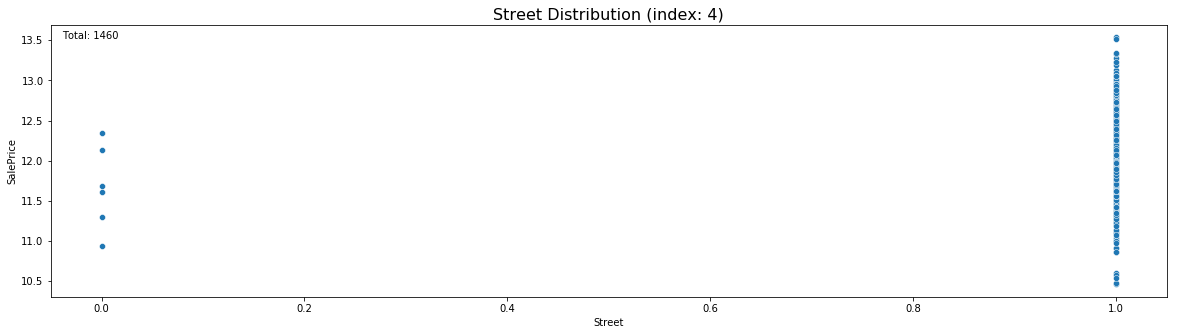

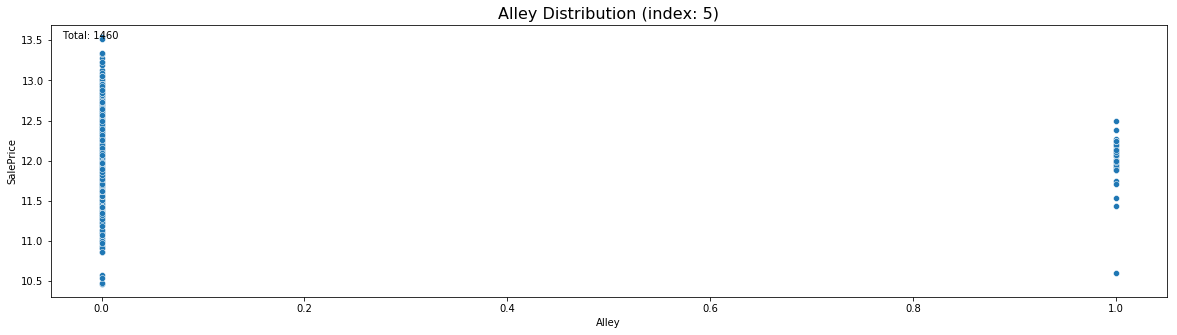

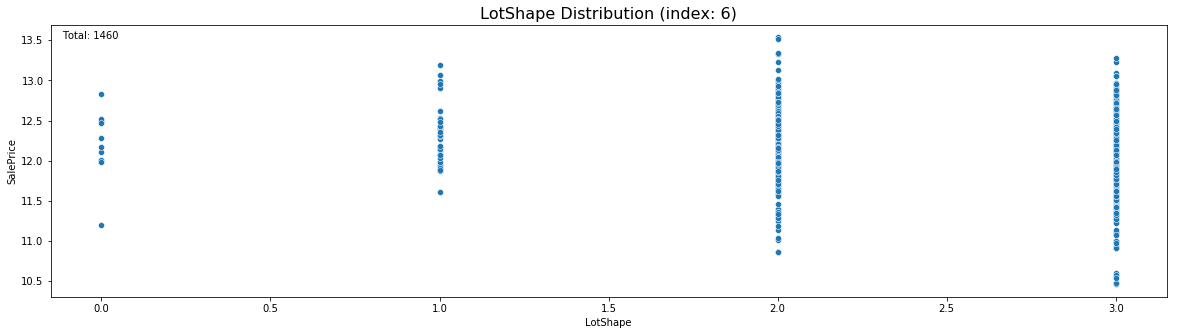

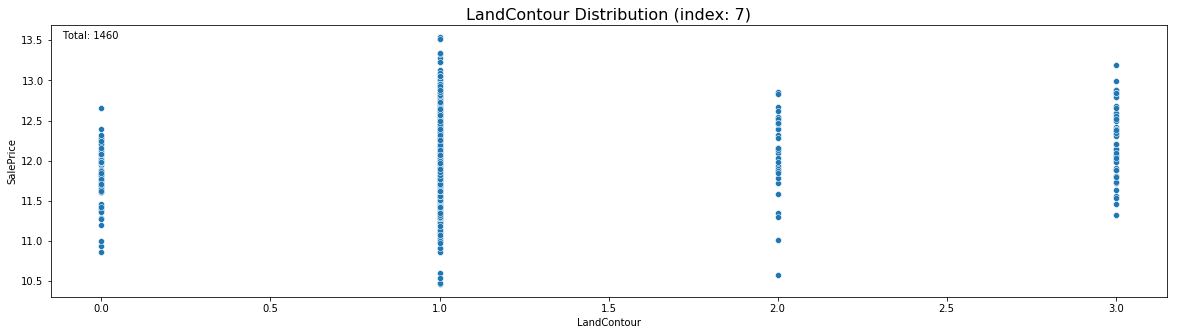

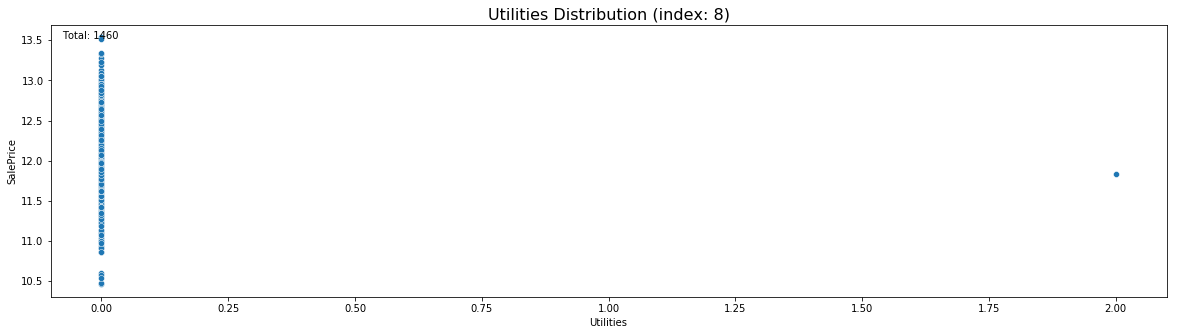

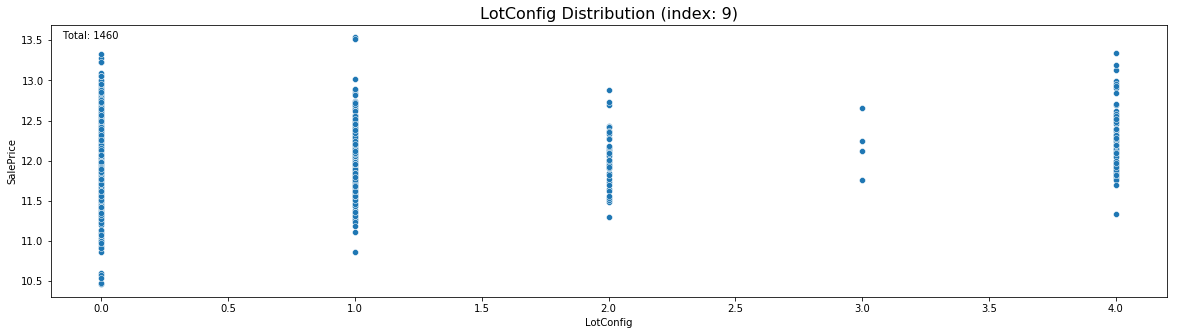

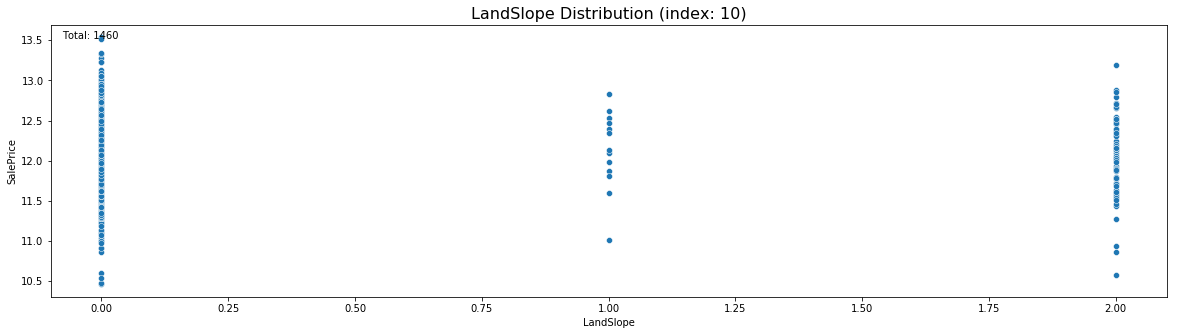

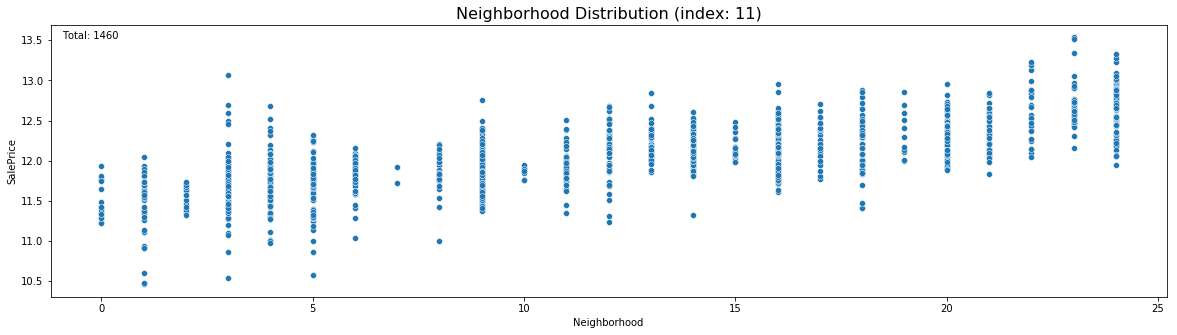

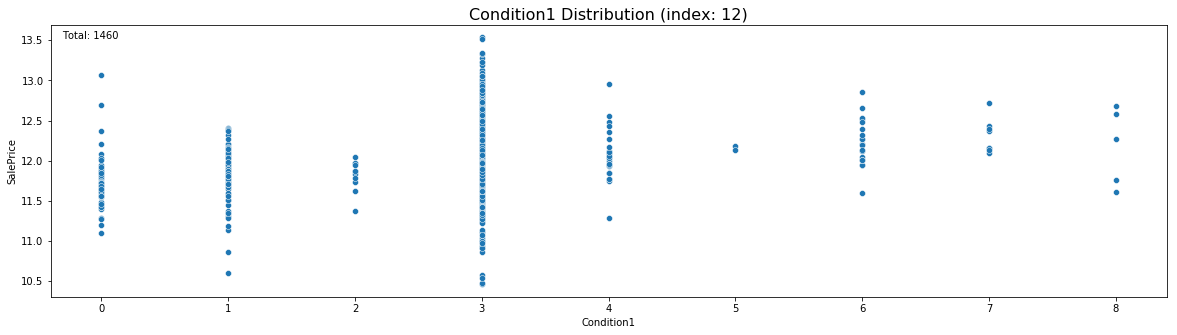

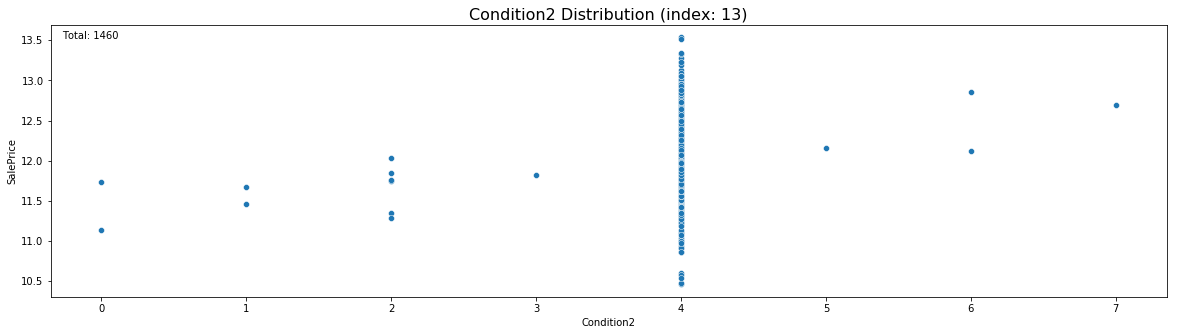

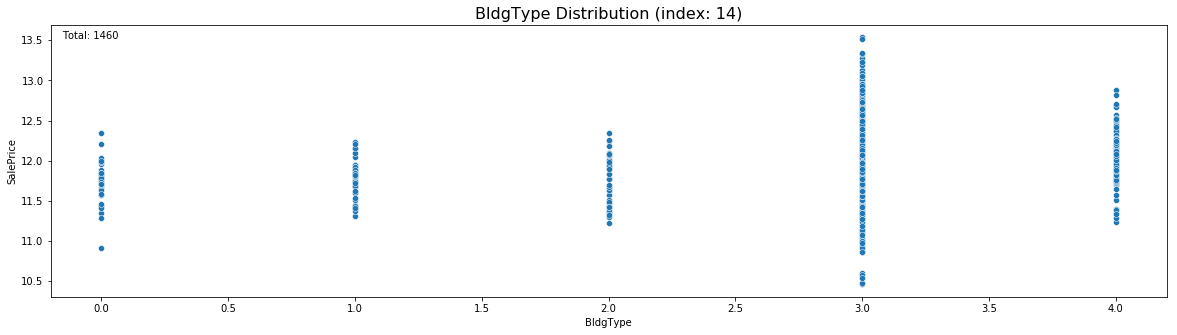

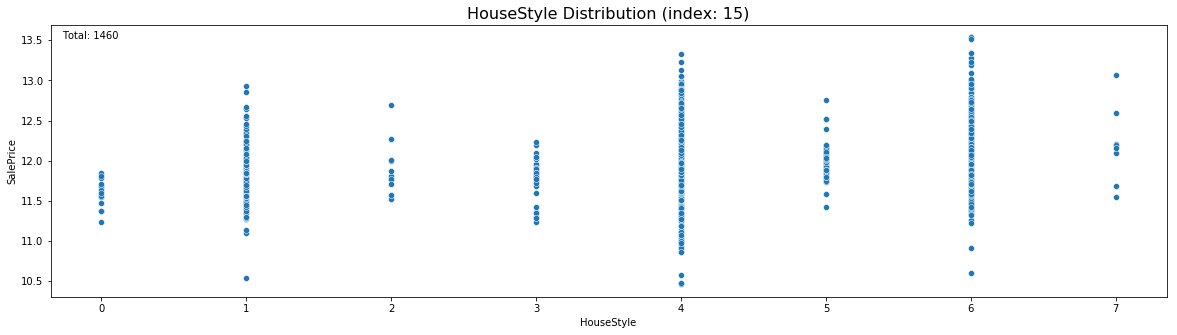

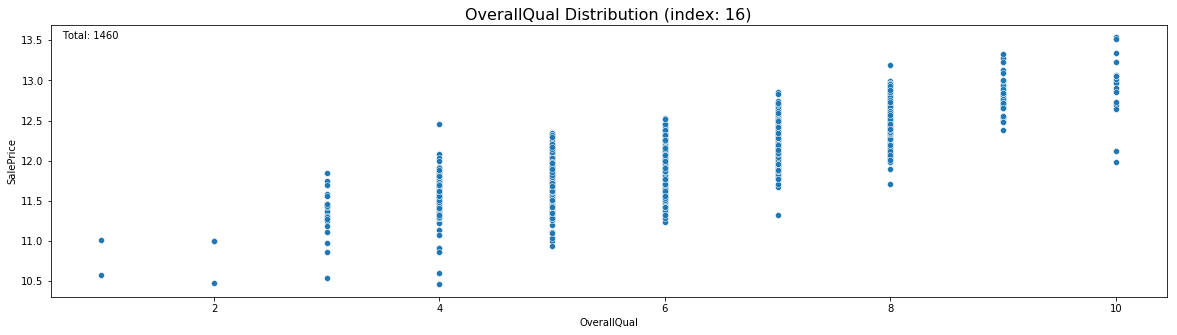

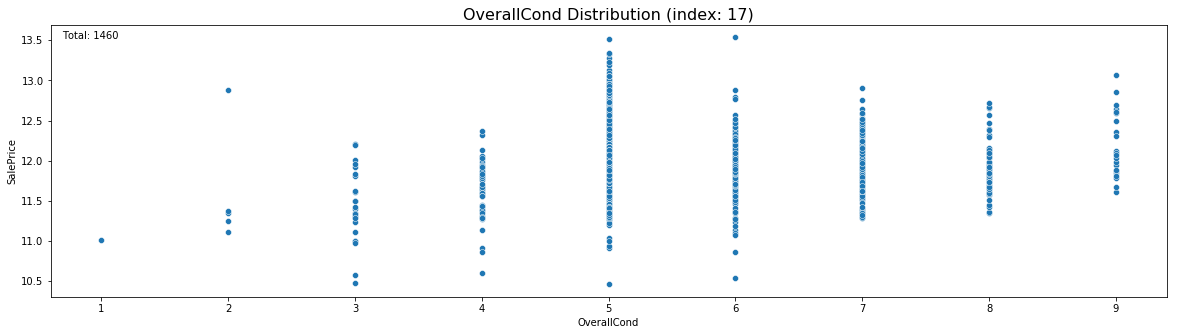

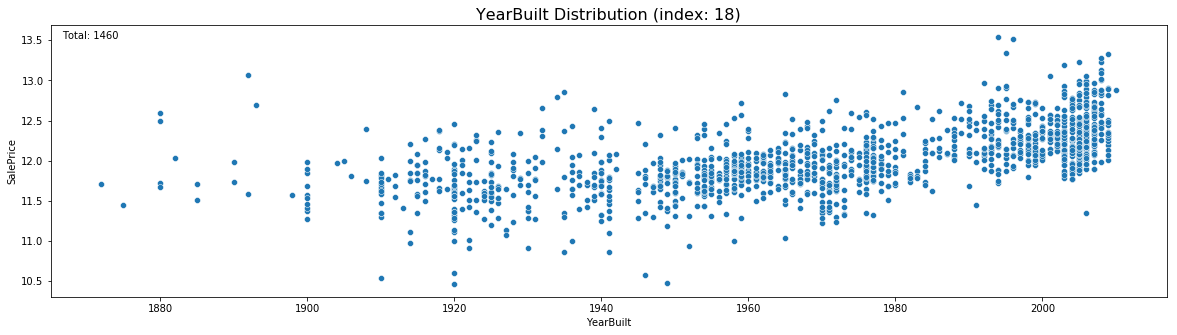

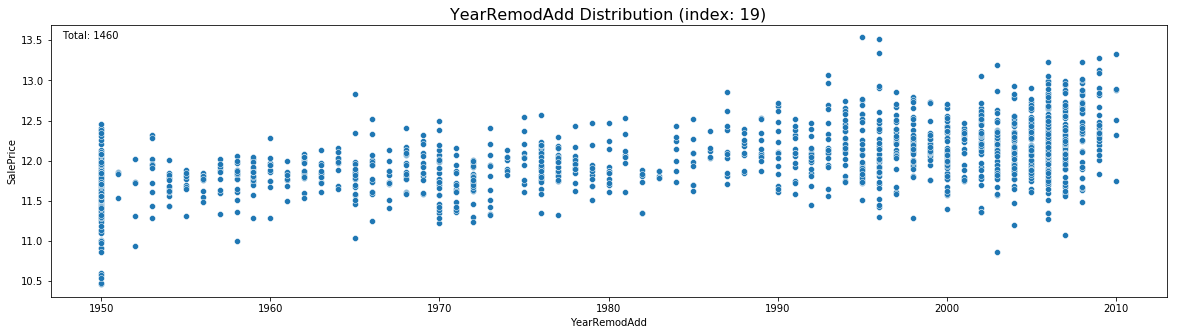

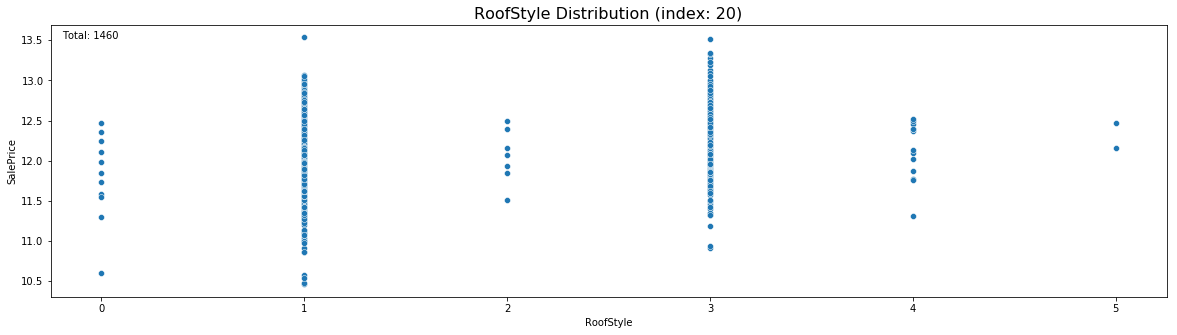

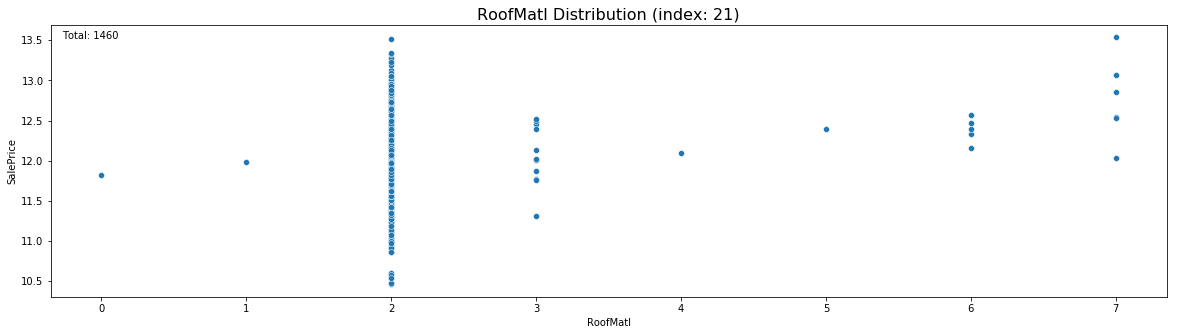

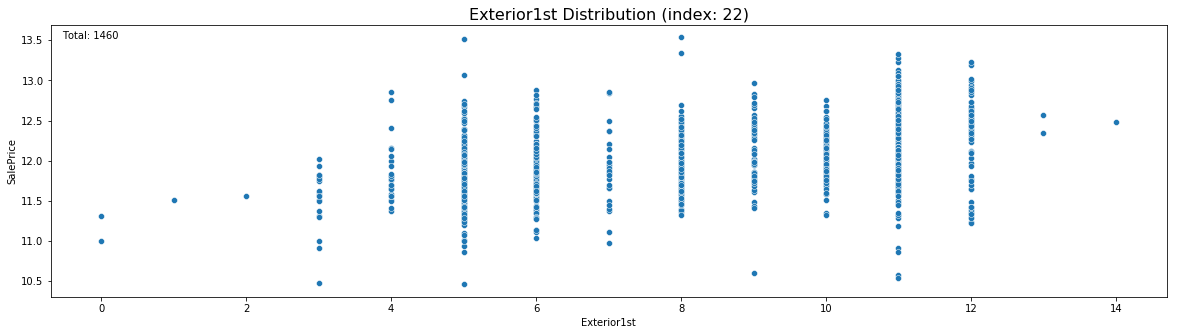

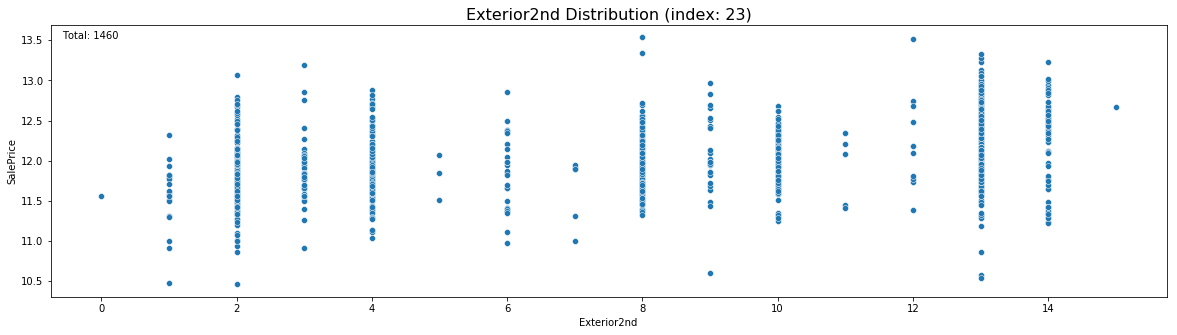

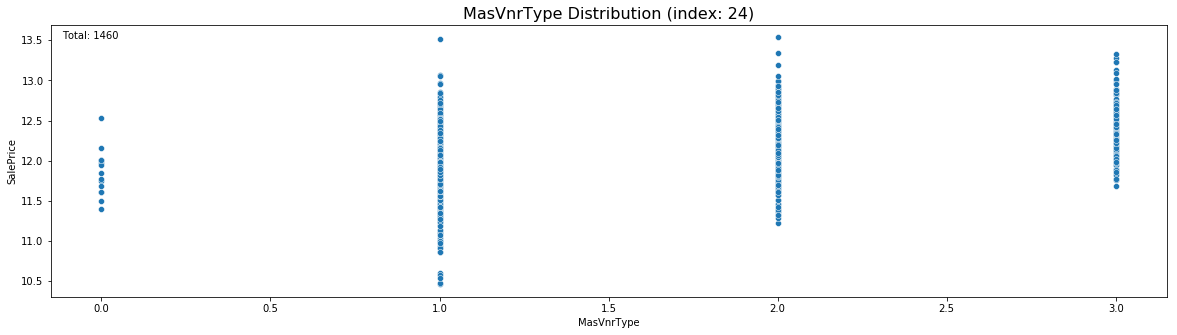

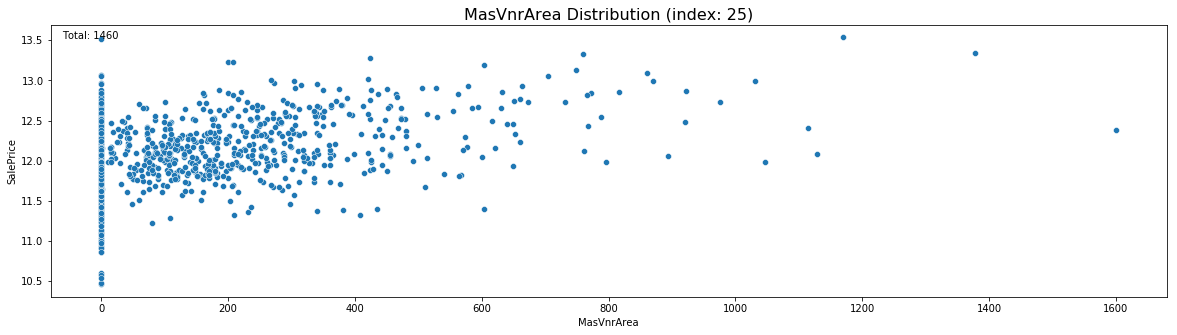

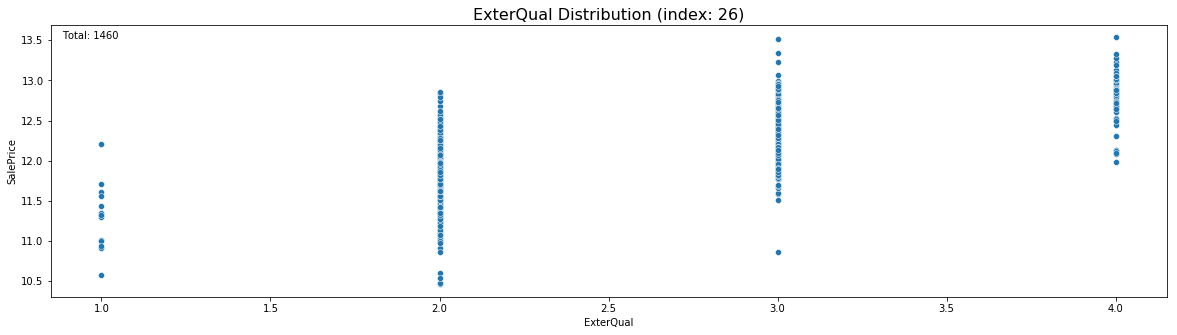

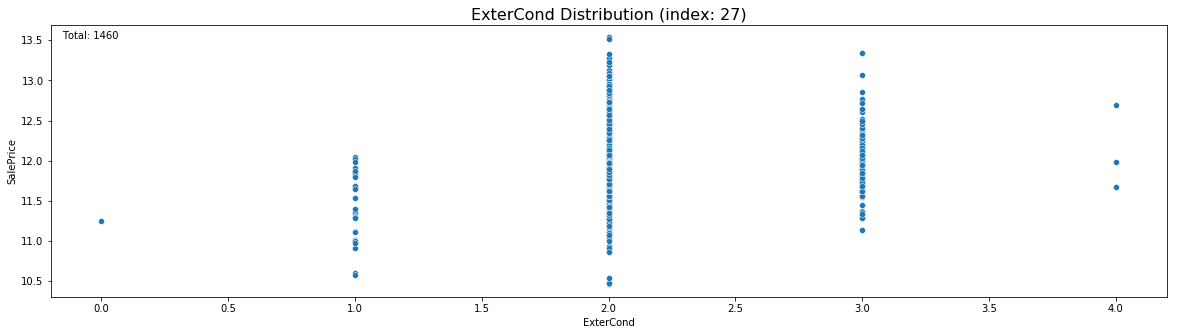

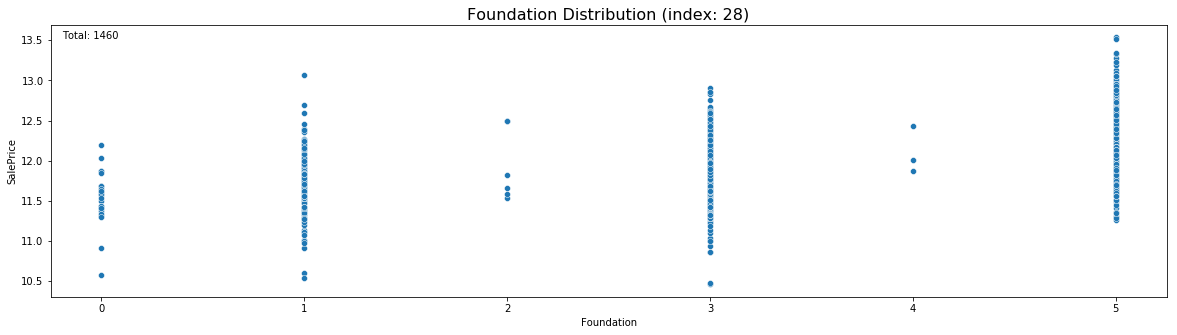

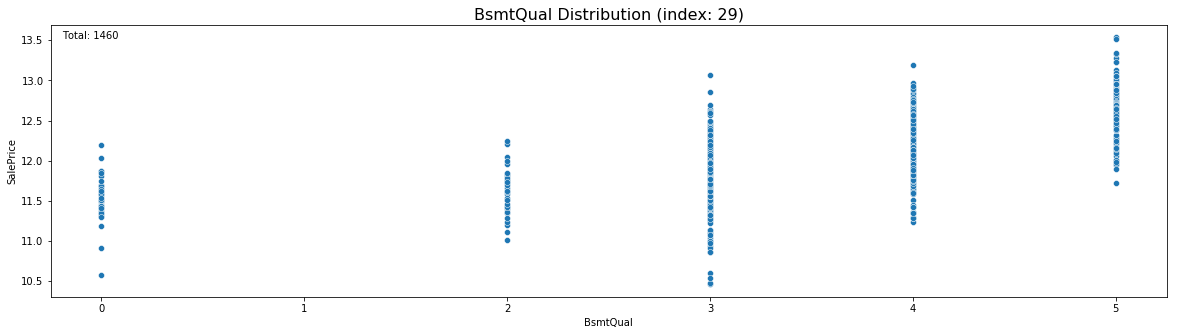

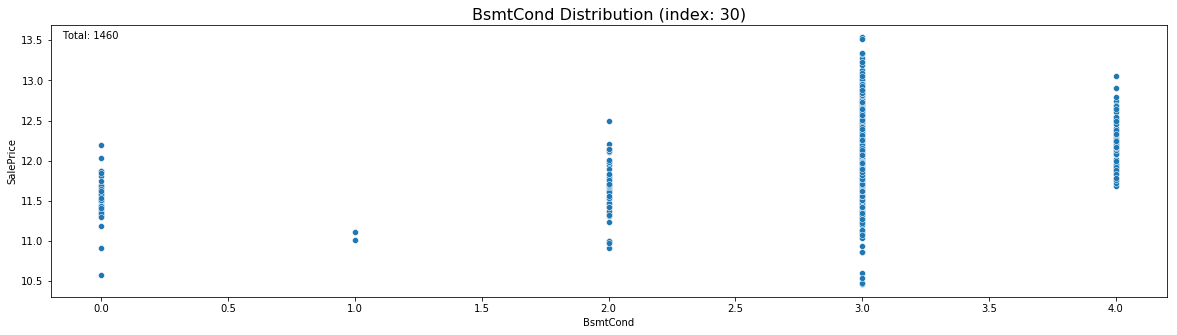

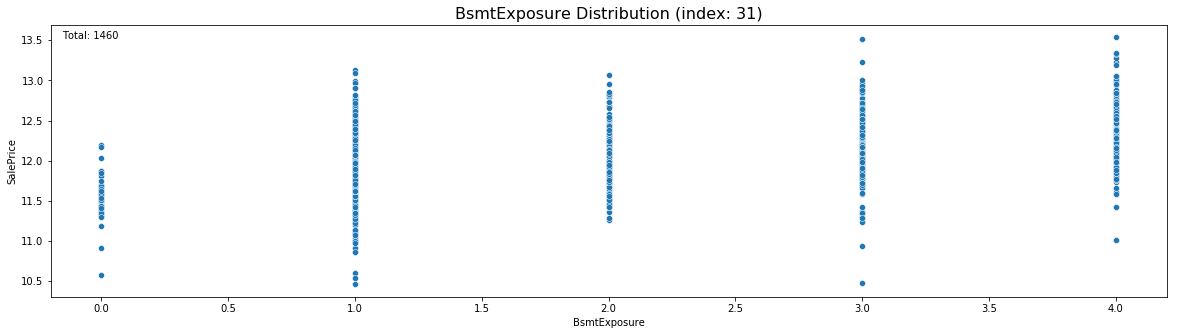

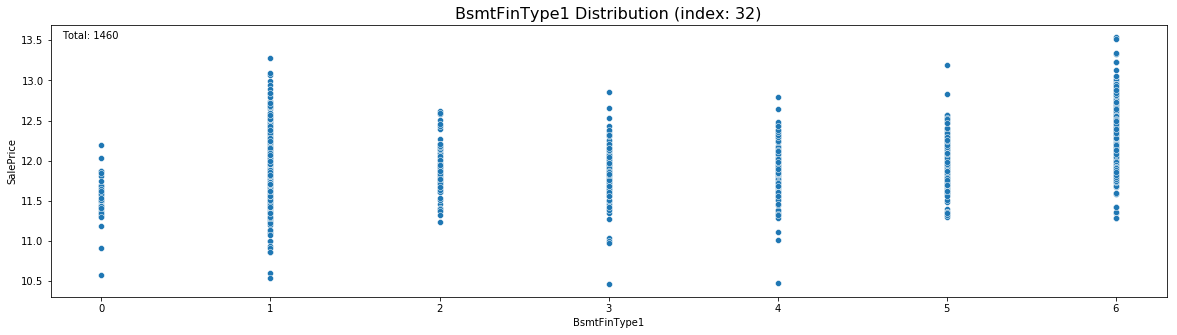

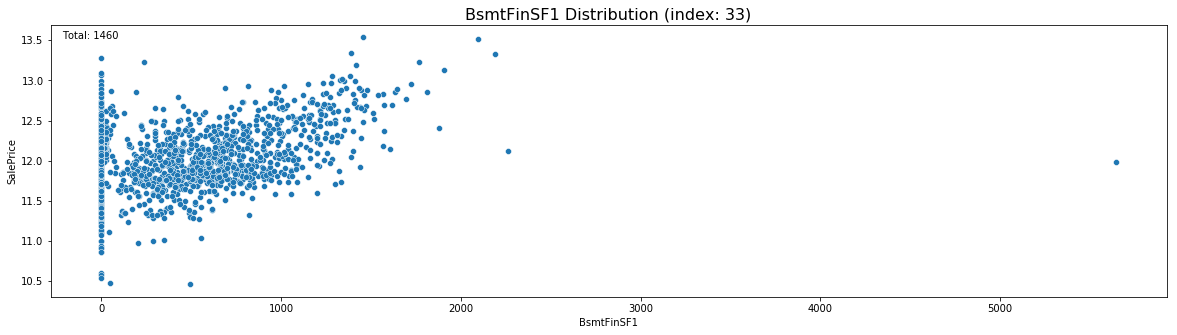

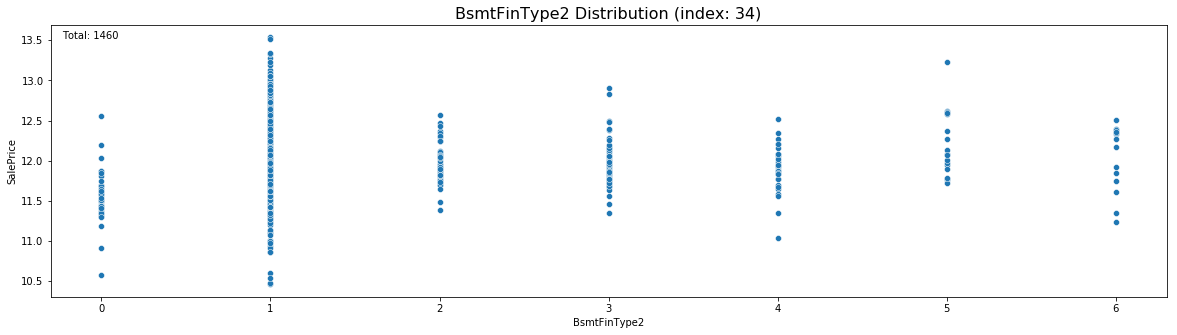

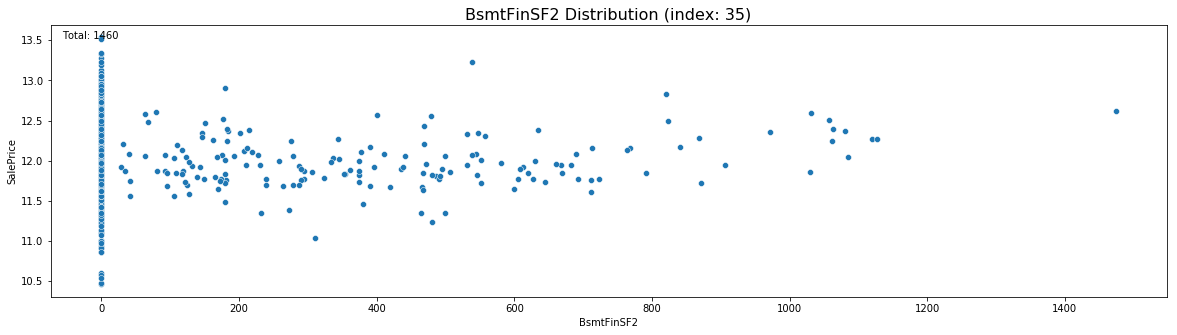

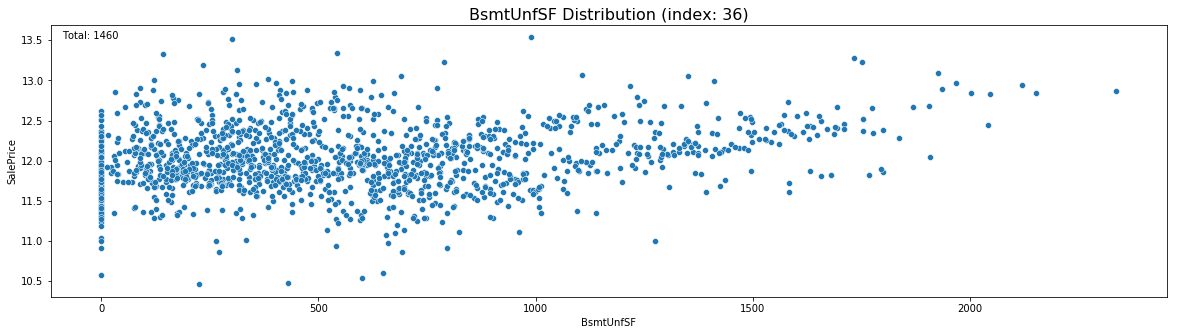

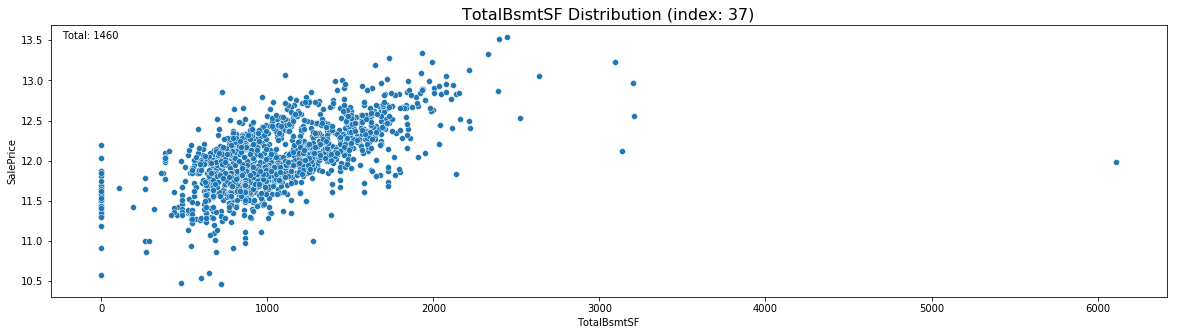

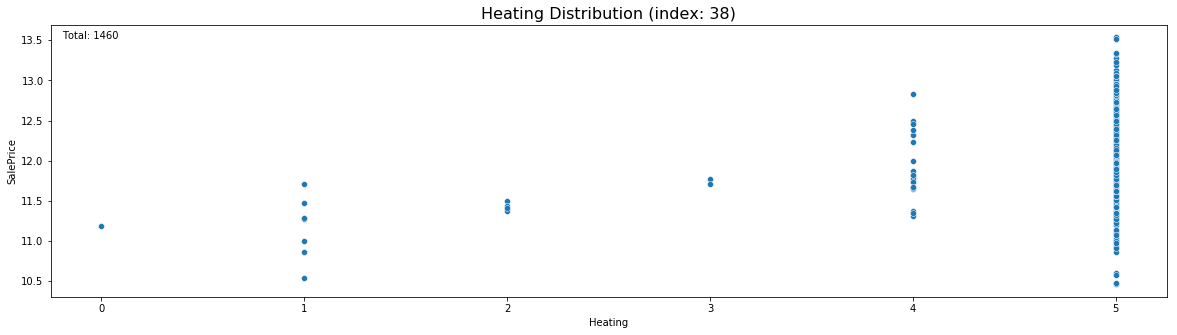

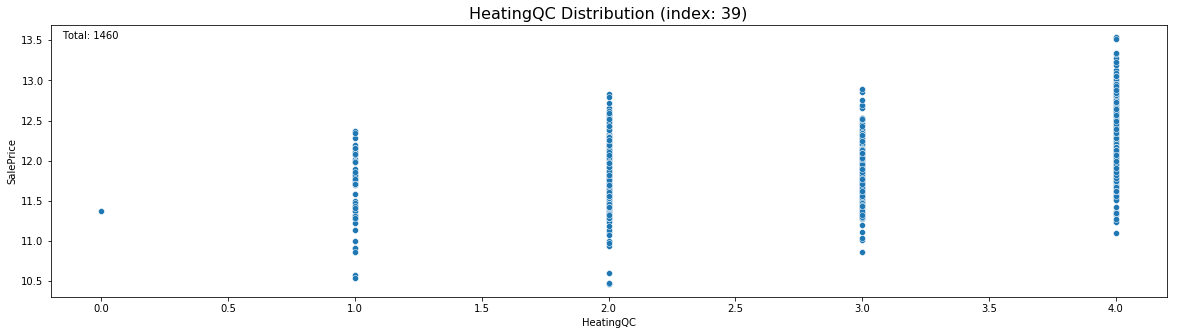

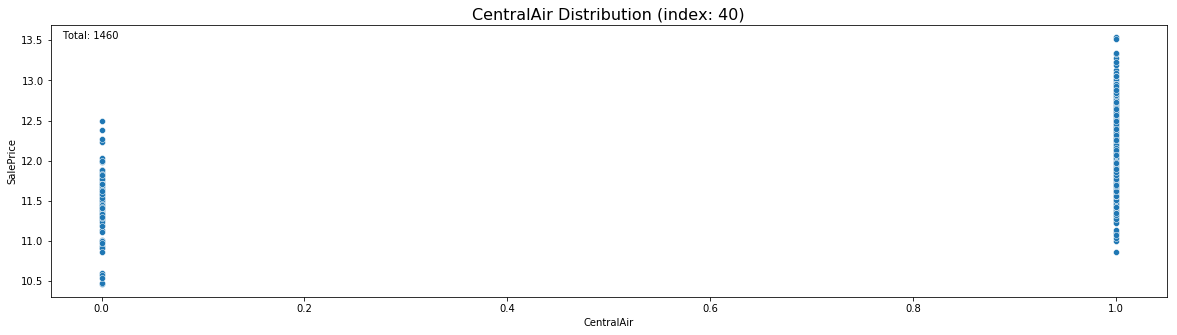

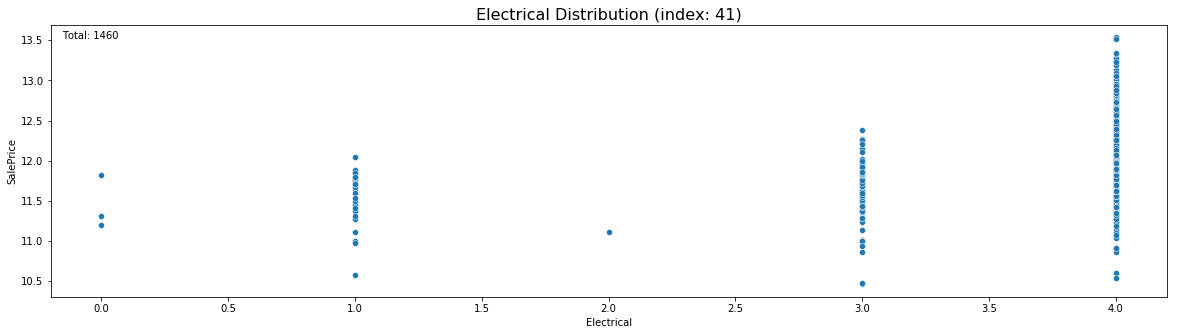

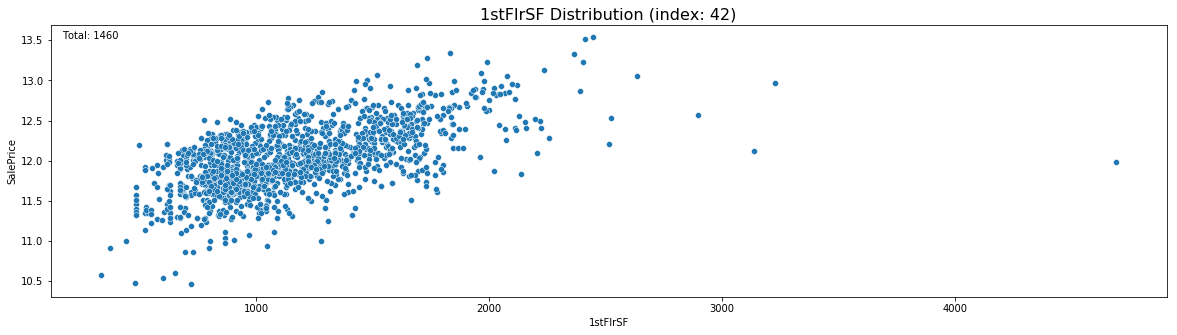

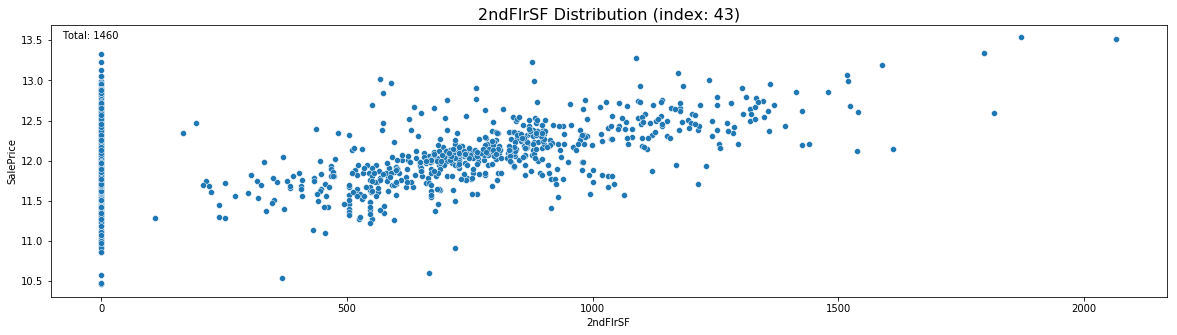

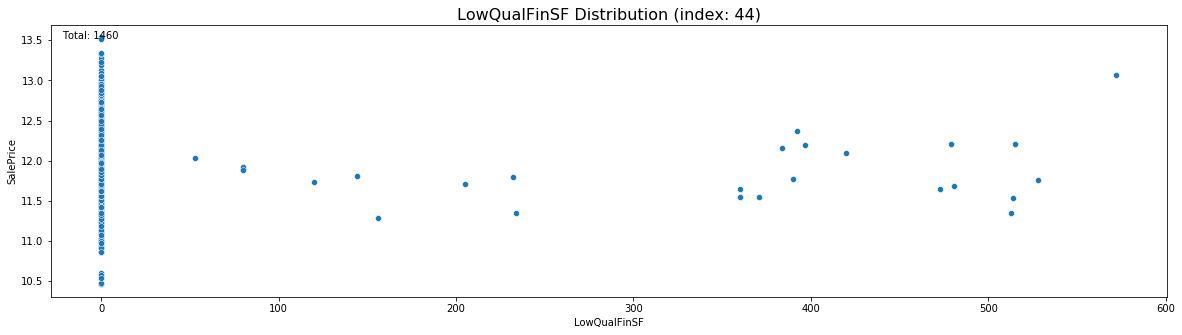

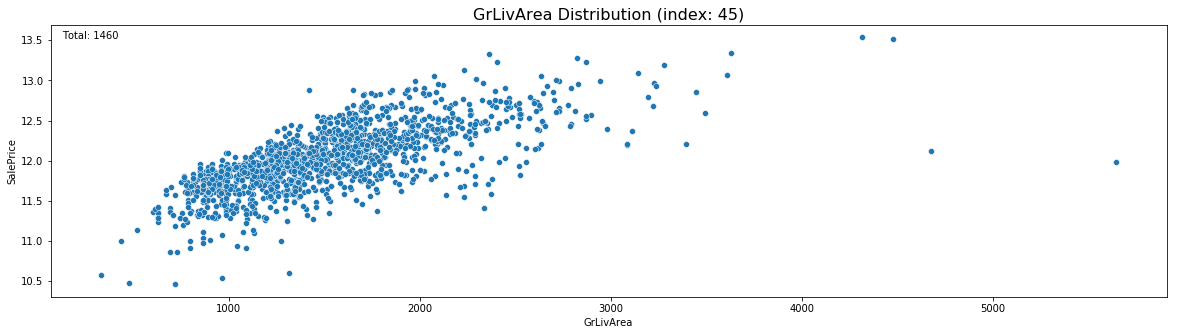

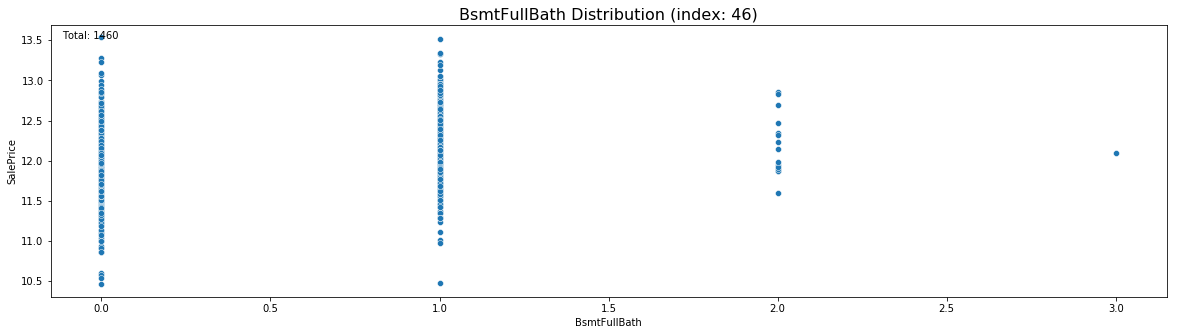

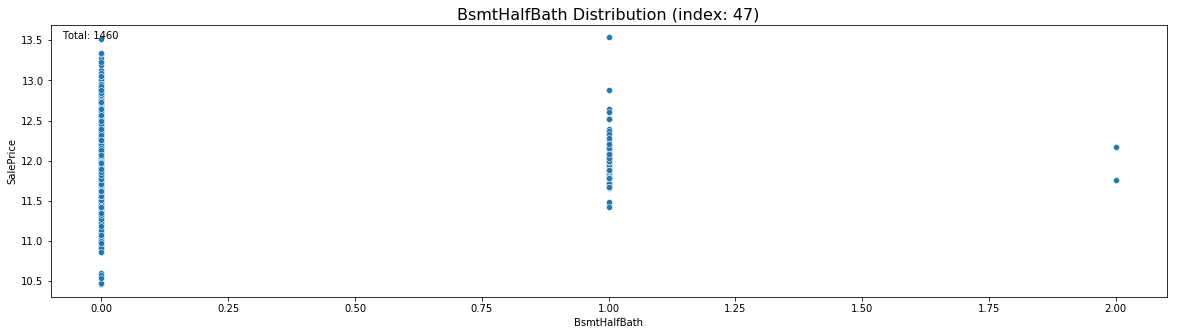

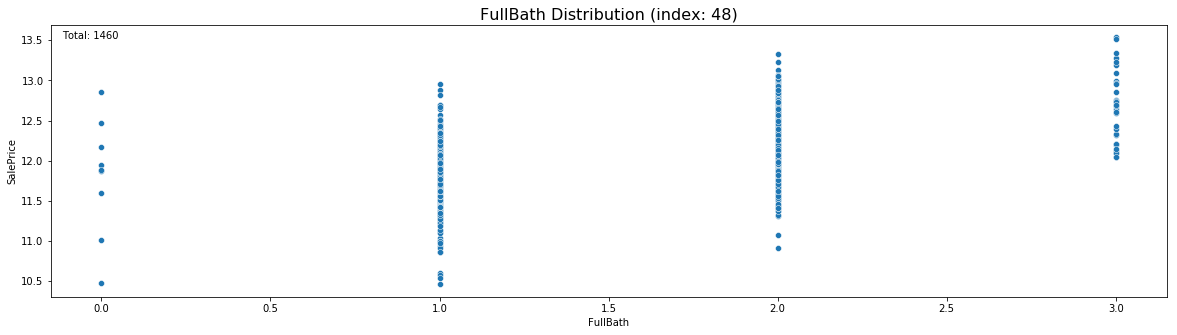

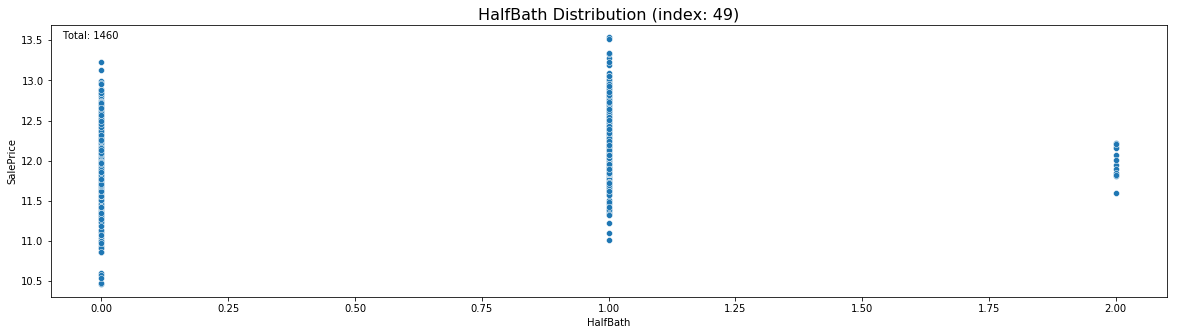

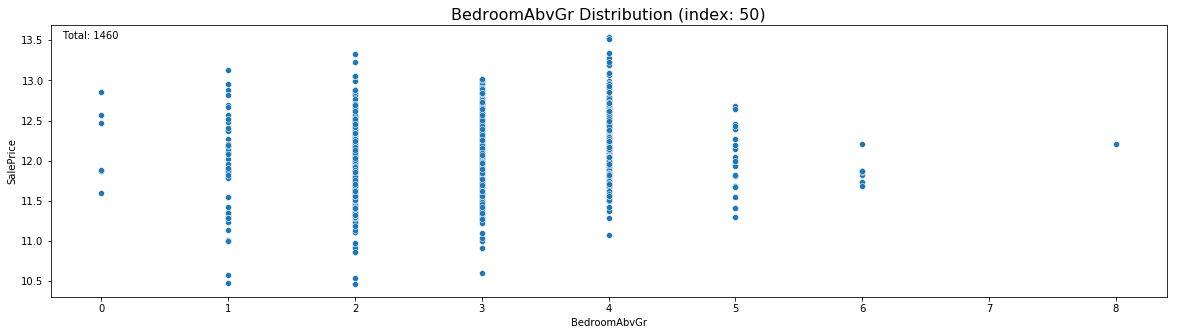

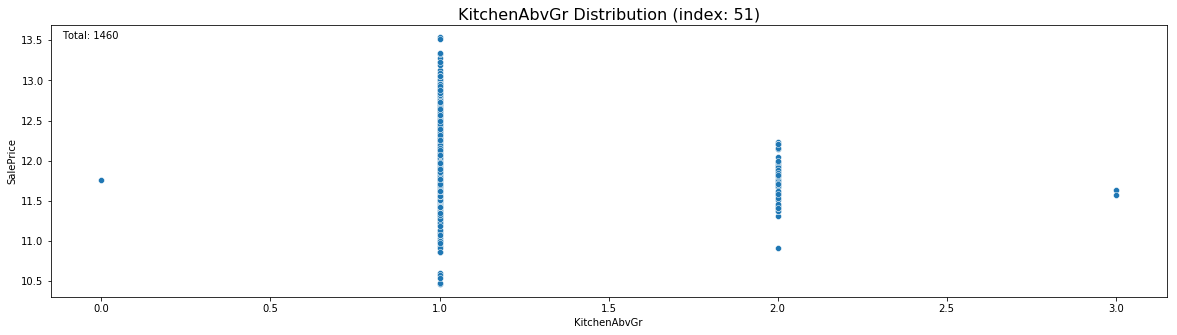

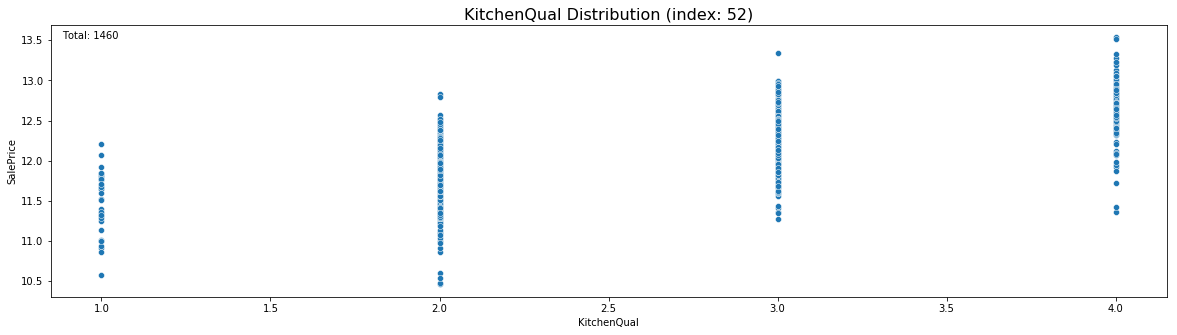

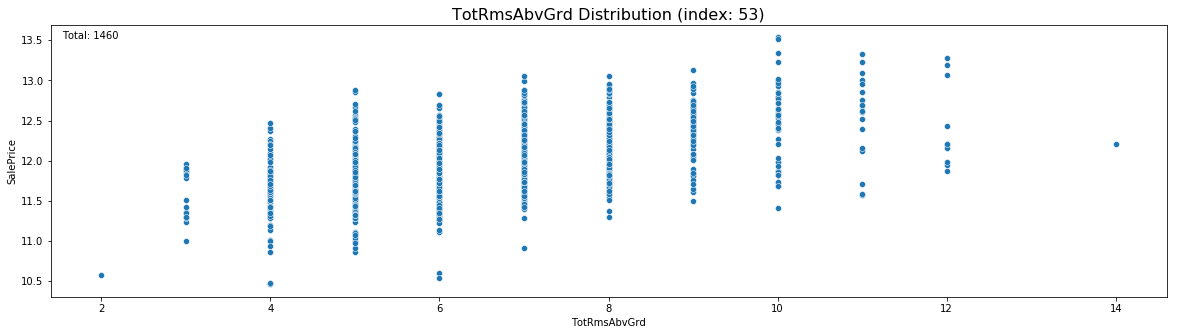

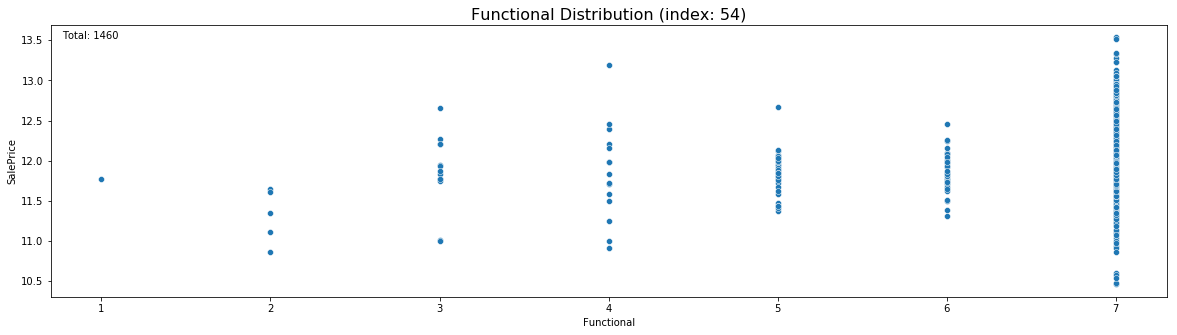

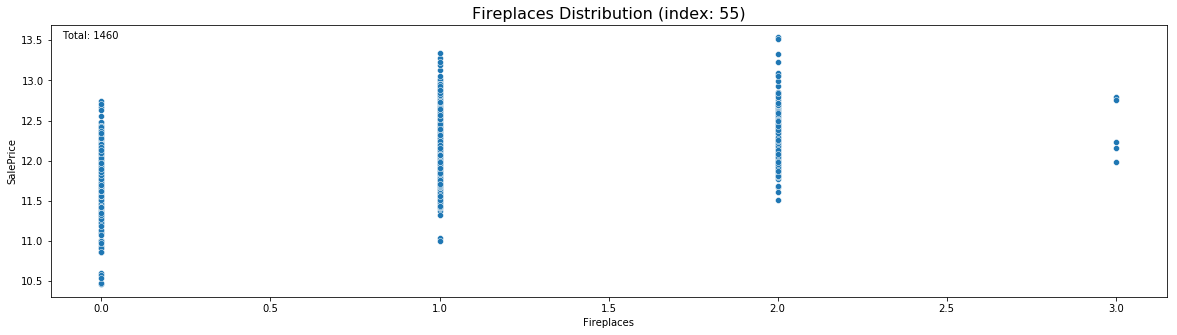

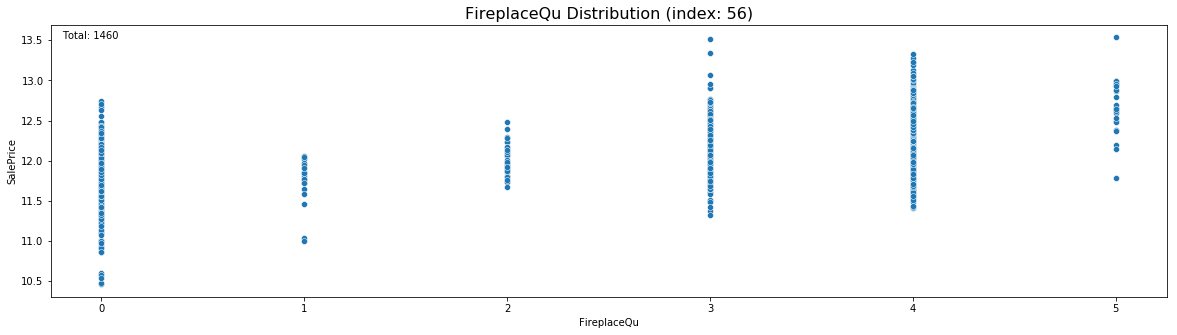

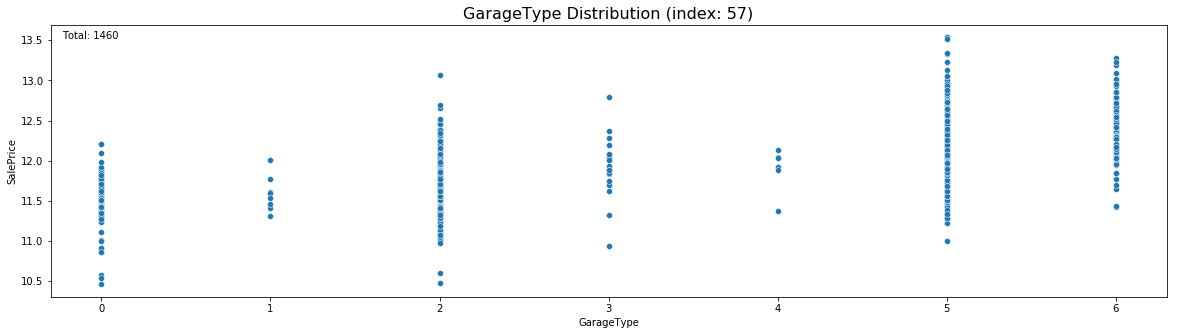

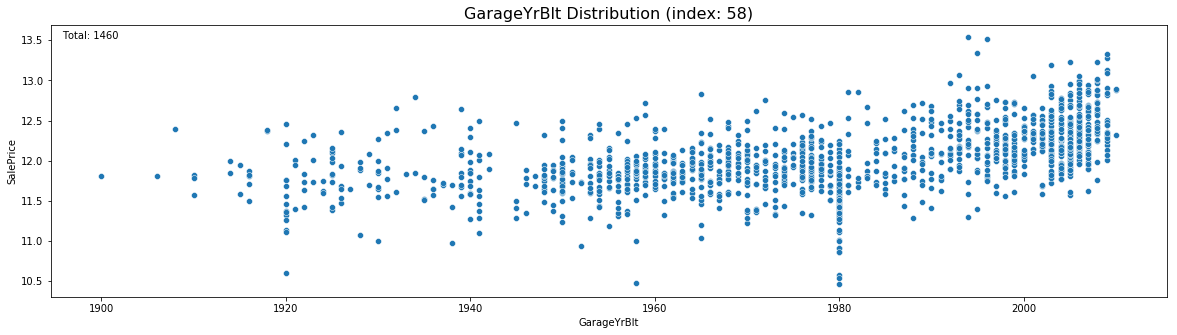

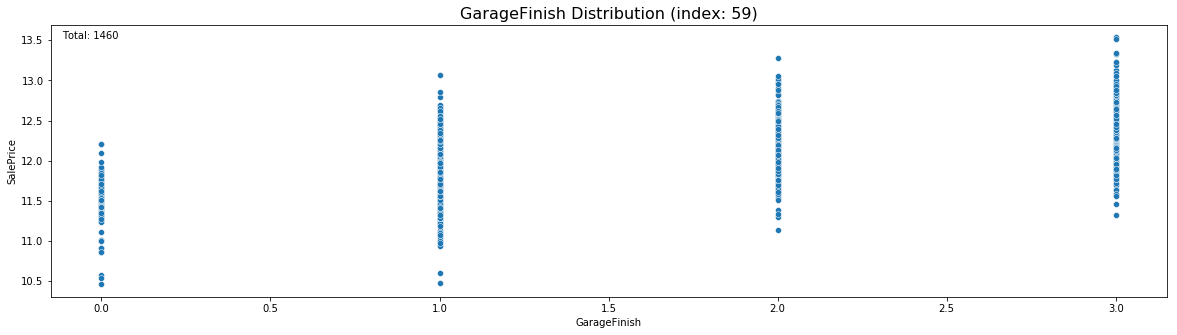

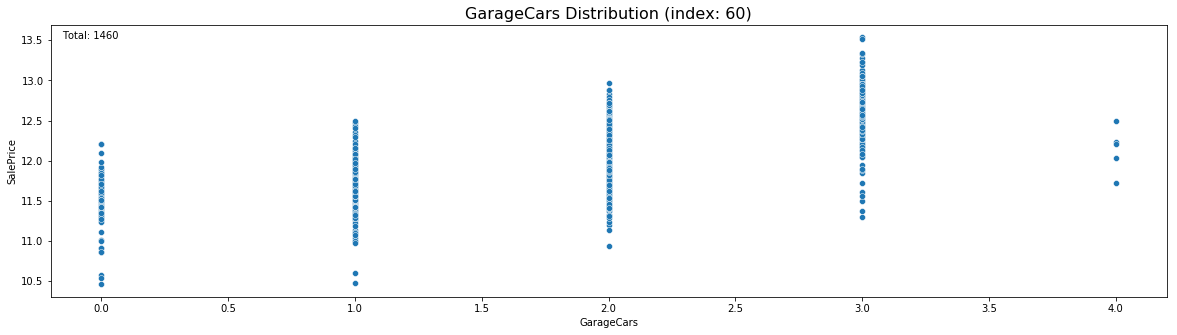

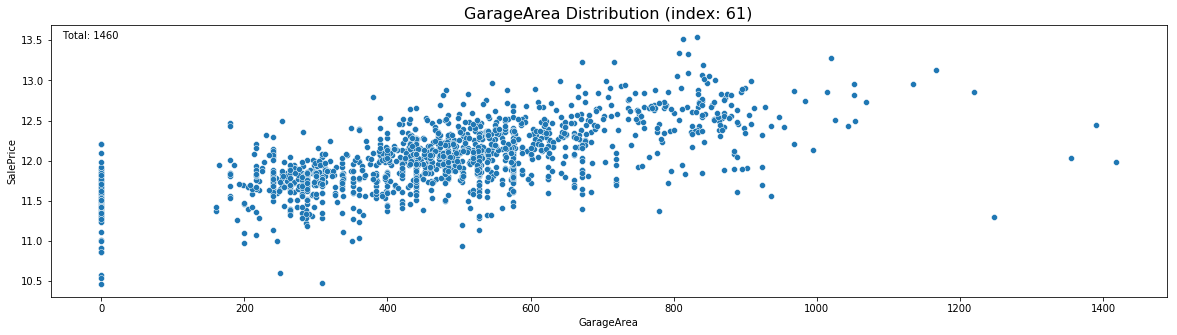

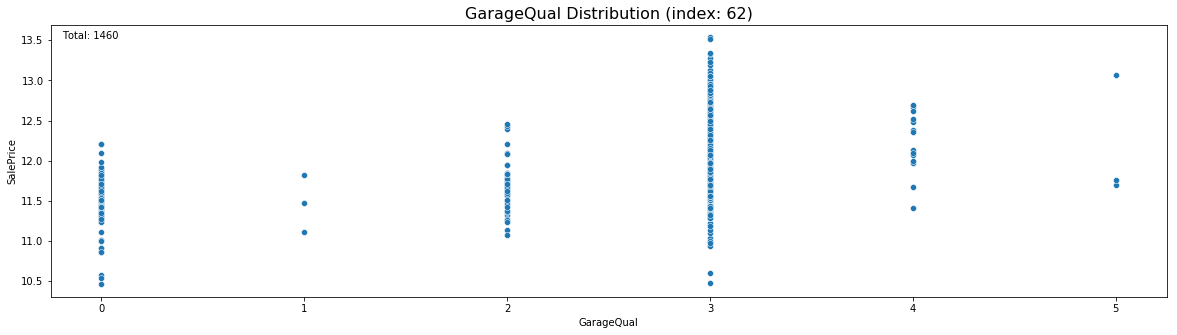

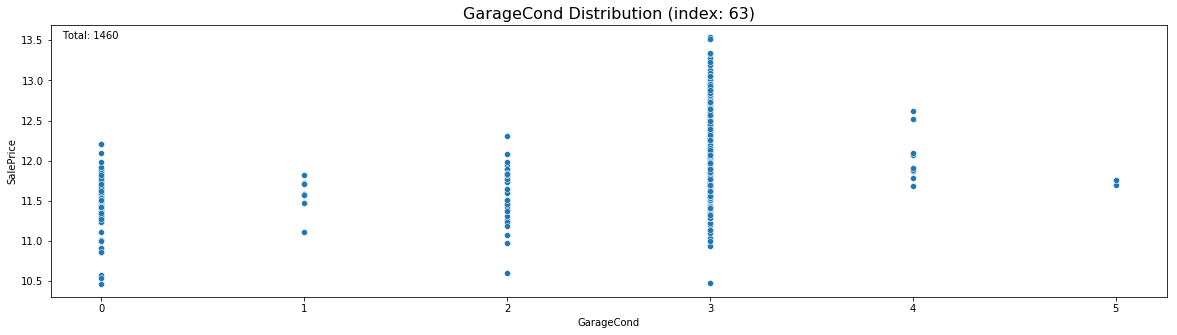

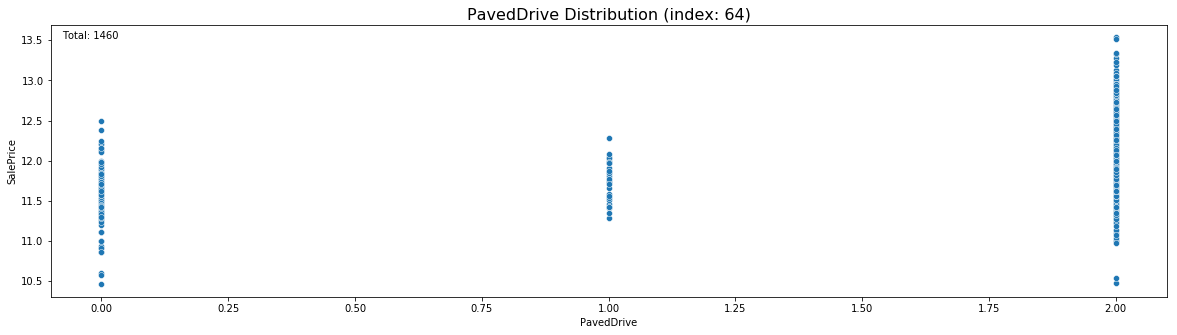

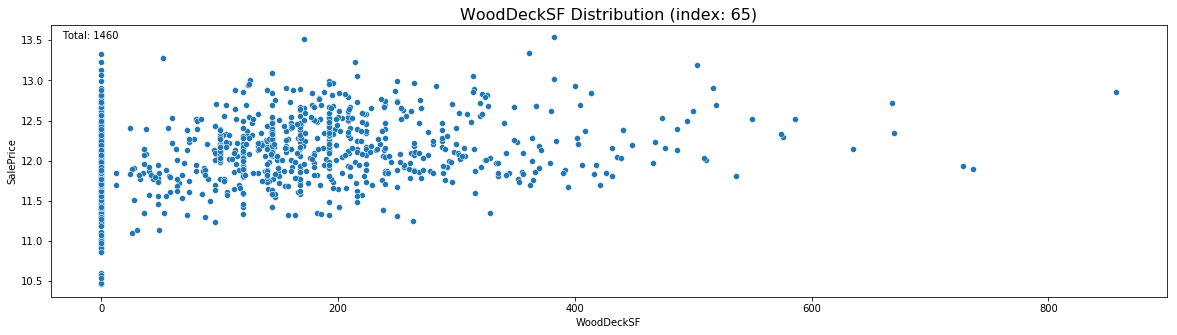

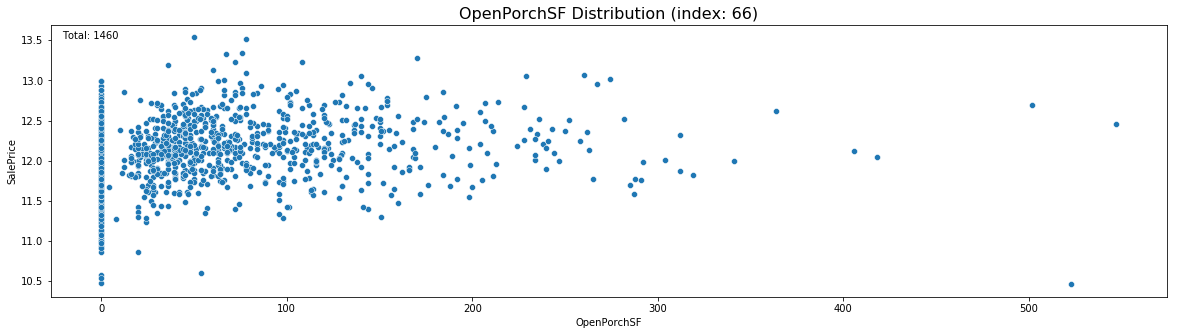

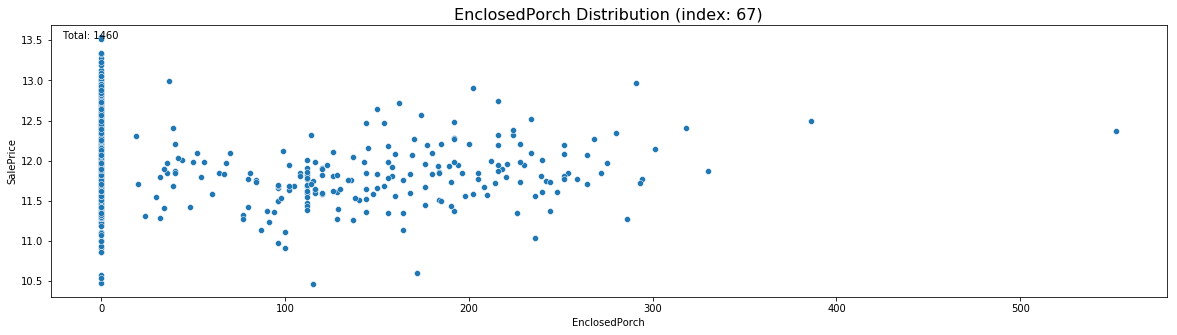

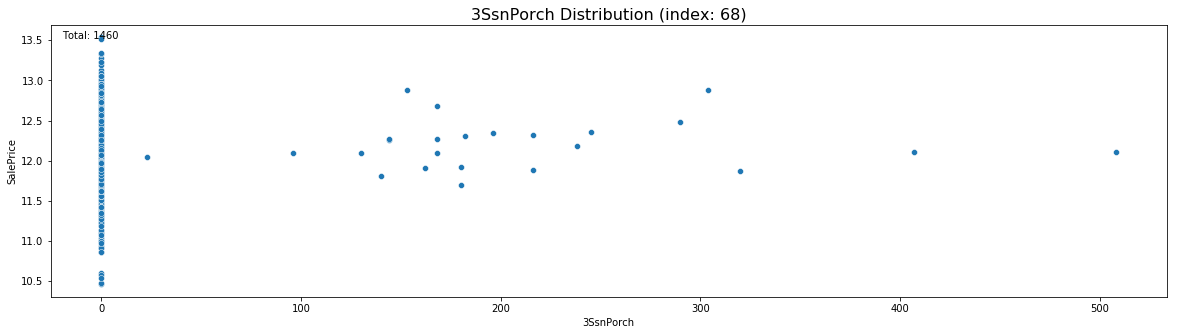

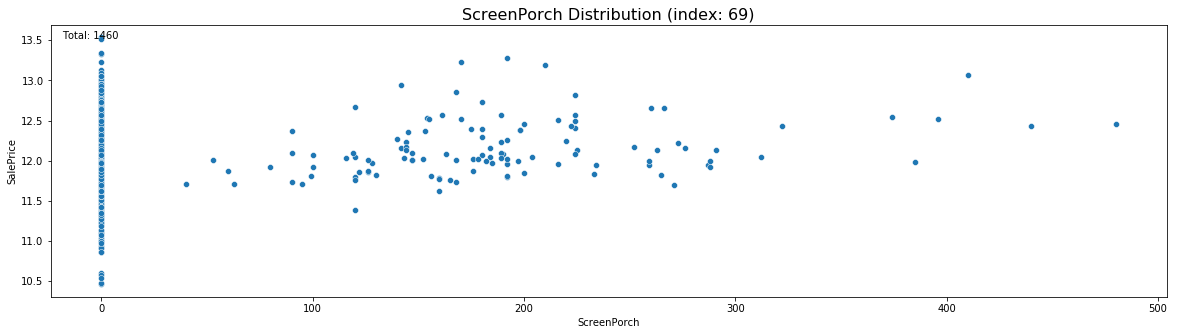

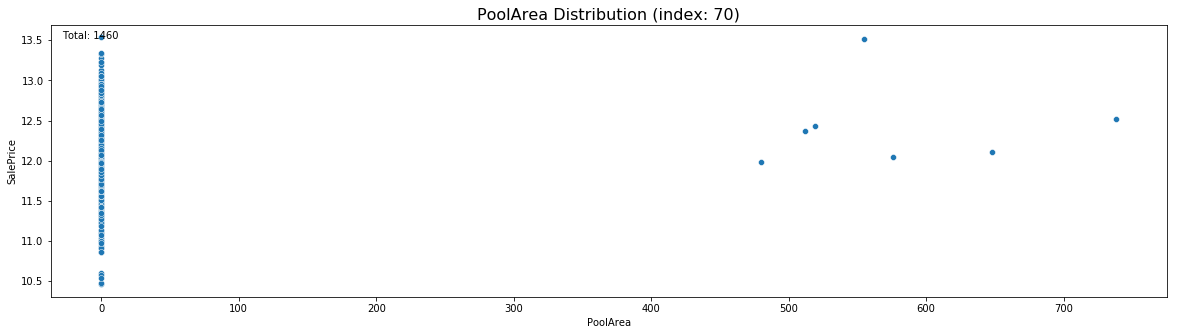

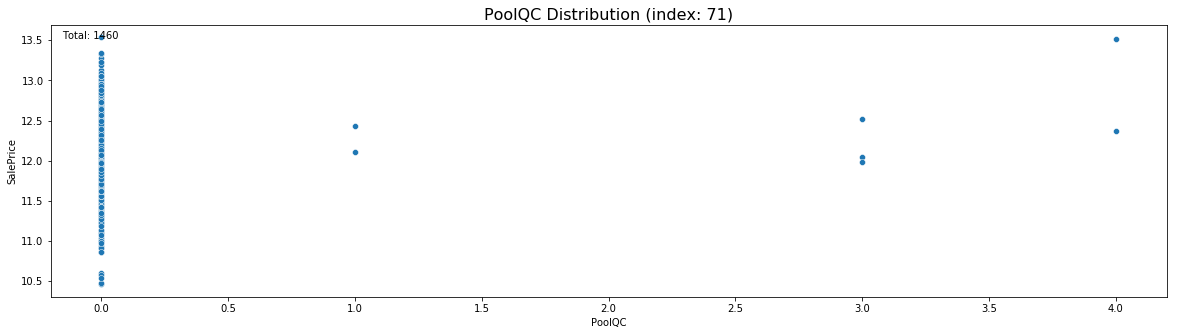

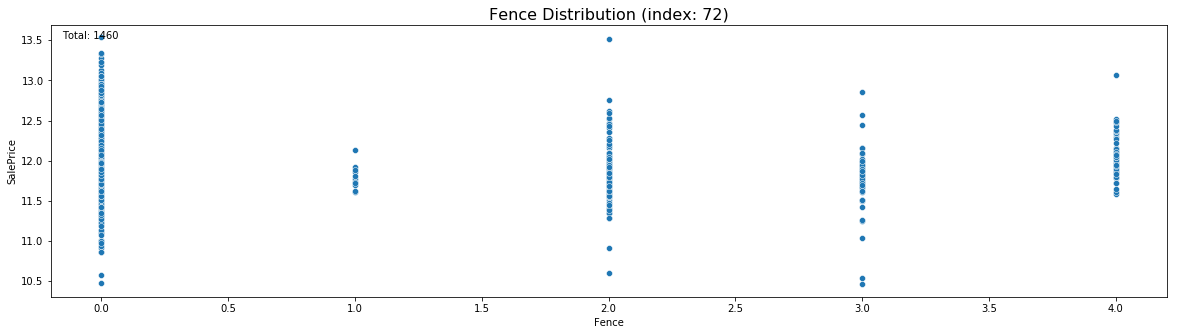

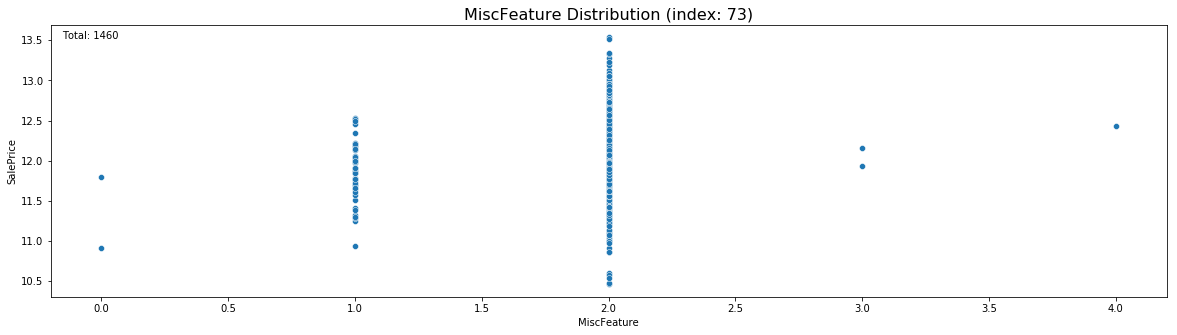

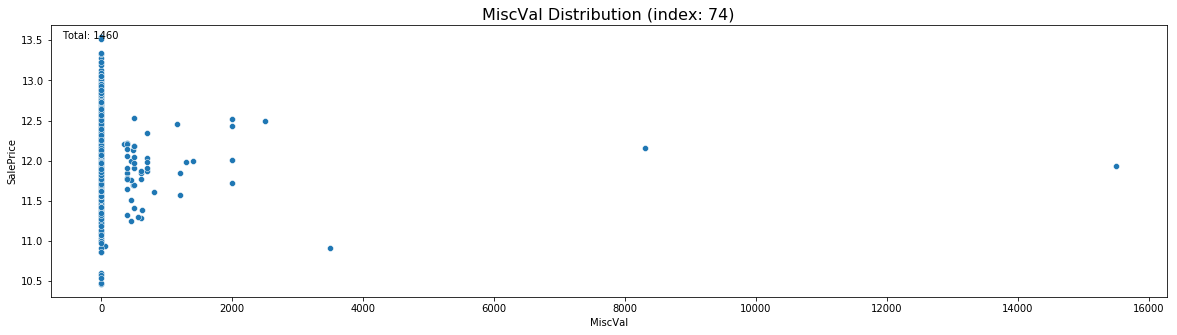

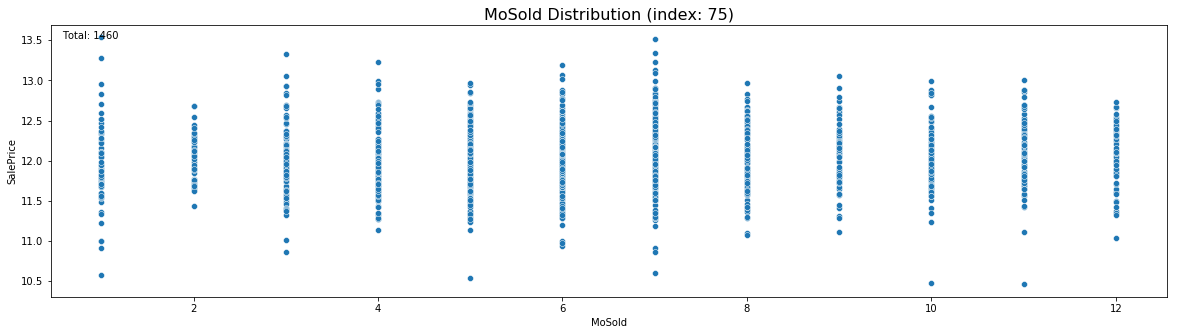

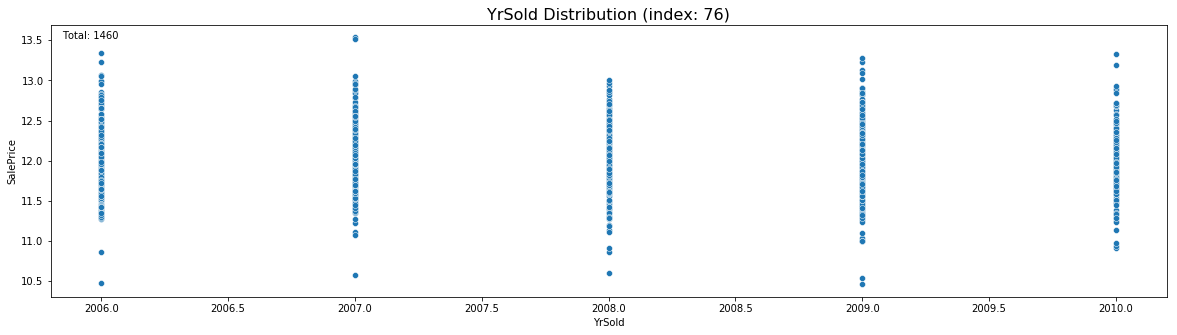

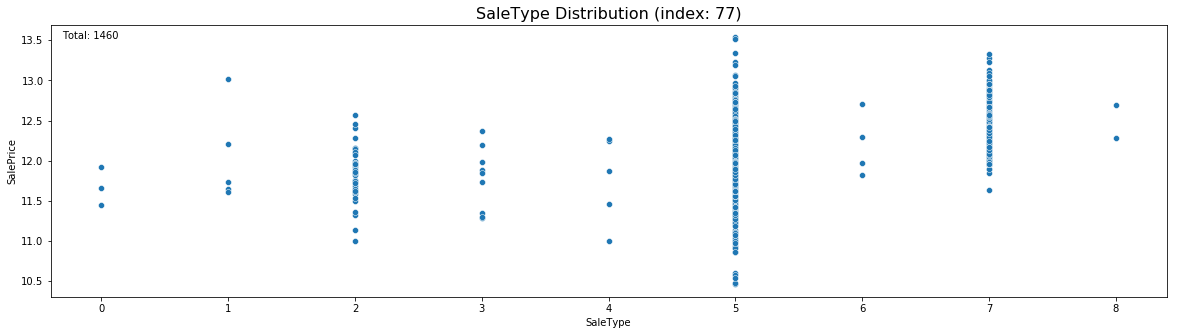

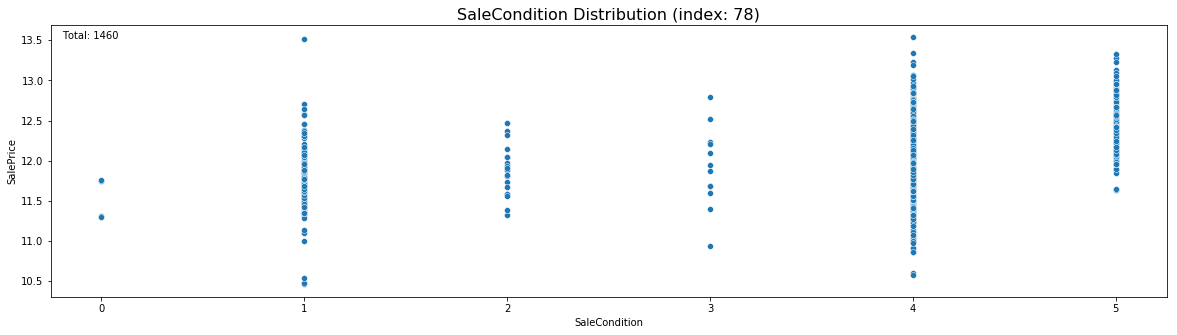

In [8]:
# ------------------------ Plot Data Distributions (post-encoding) ------------------------- #
custom_plot.data_distribution_scatters(X, y)
# ------------------------------------------------------------------------------------------ #

###### EDA

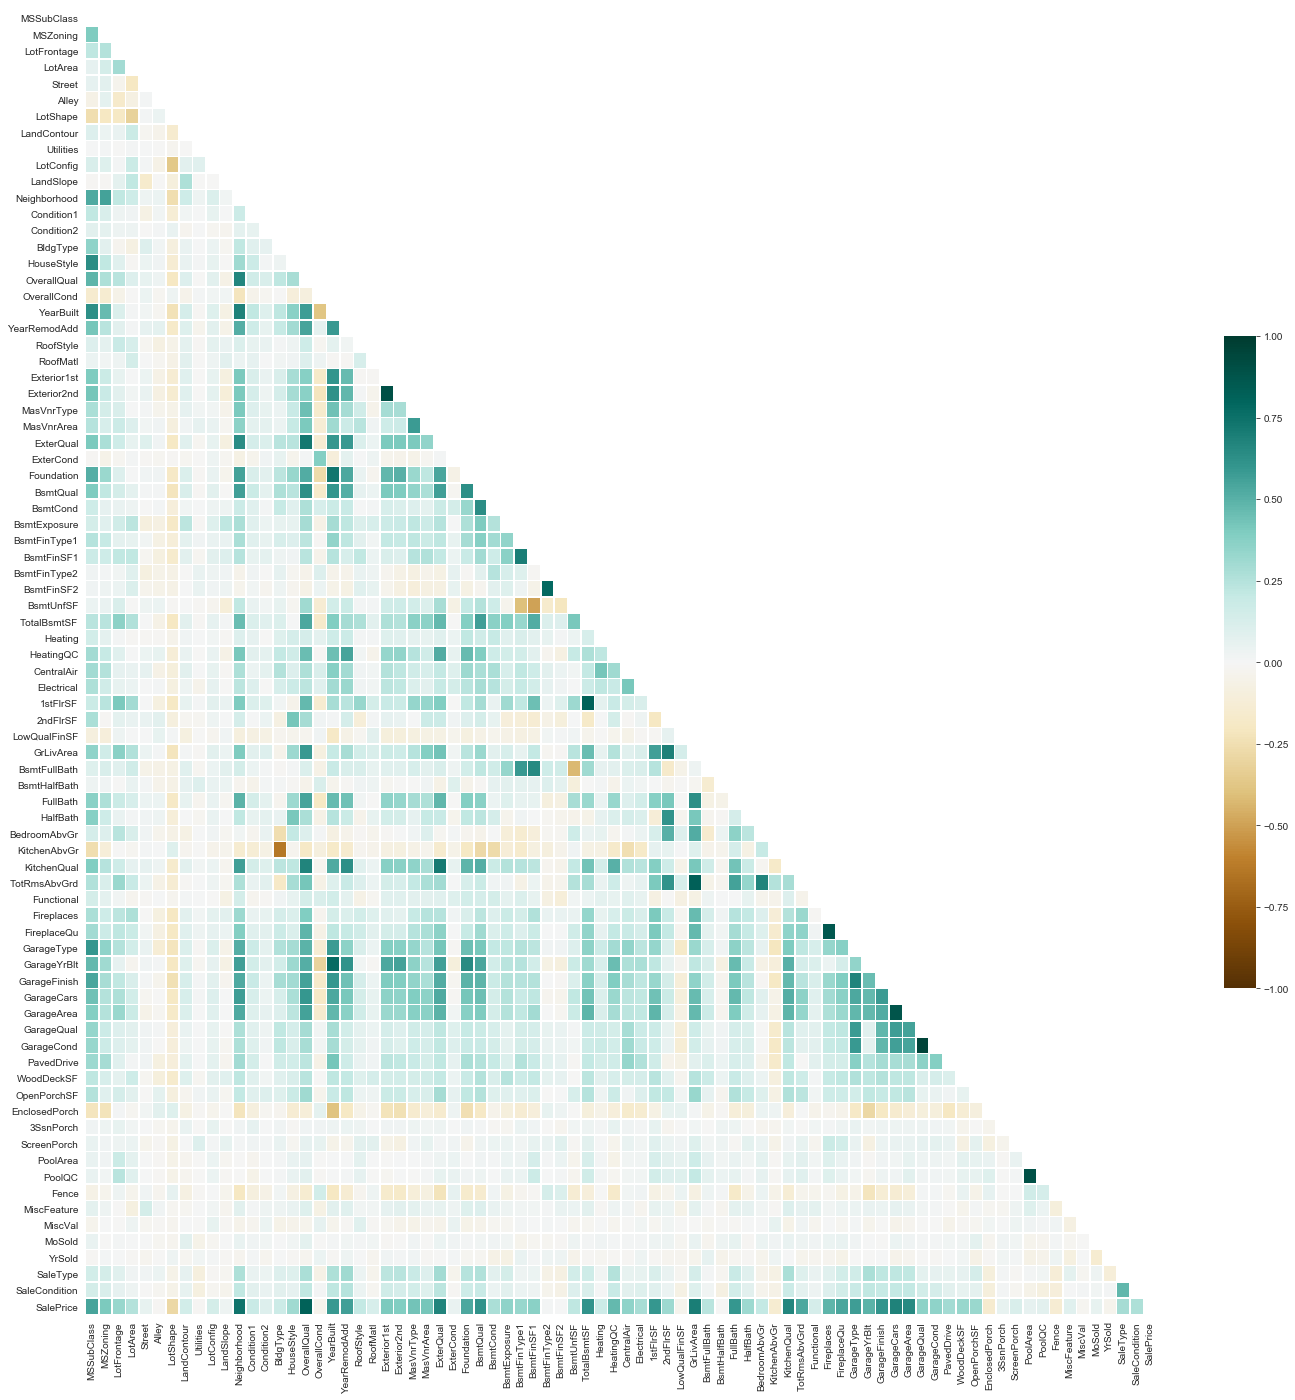

In [9]:
custom_plot.features_heatmap(train)


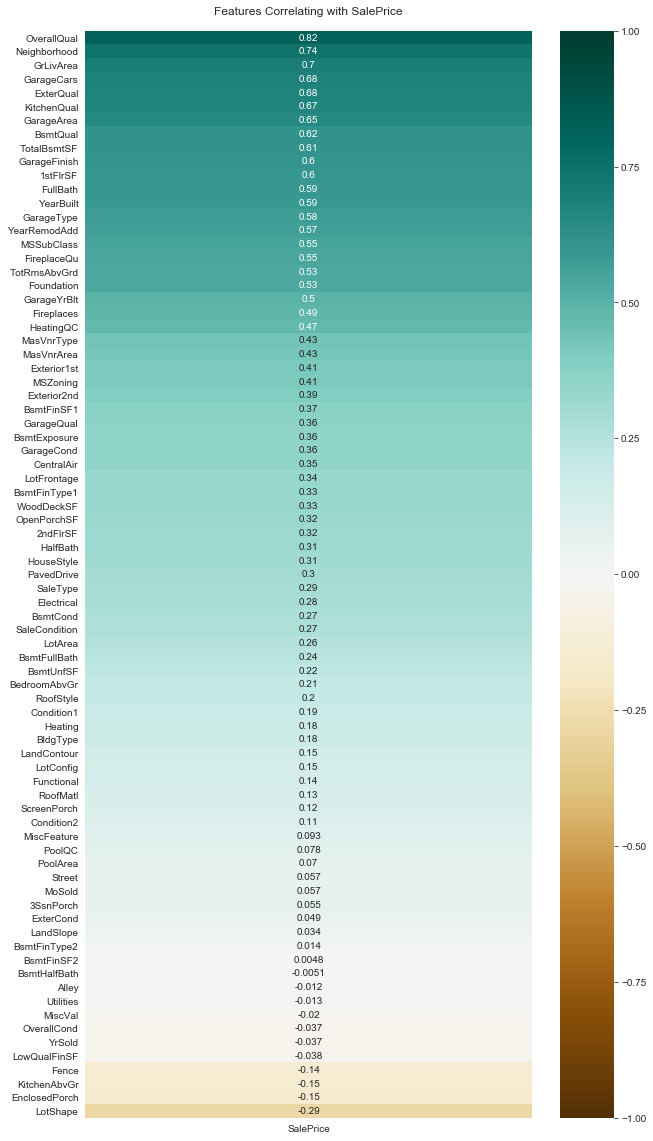

In [10]:
custom_plot.target_heatmap(train, 'SalePrice')


In [11]:
# Base Models
rs = 42

base_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=rs),
    'Random Forest': RandomForestRegressor(random_state=rs),
    'Gradient Boost': GradientBoostingRegressor(random_state=rs),
}

###### Model Testing

In [12]:
# train/validation splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=rs)

# --------------------------------------- TRAINING ERROR ----------------------------------------------------- #
data = {}
for model_name, model in base_models.items():
    # regular sale price predictions/score
    MAE = score_log_dataset(X_train, X_train, y_train, y_train, model, mean_absolute_error)
    MSE = score_log_dataset(X_train, X_train, y_train, y_train, model, mean_squared_error)

    data[model_name] = [MAE, MSE]

    
print('BASELINE TRAINING ERRORS:')
print(pd.DataFrame.from_dict(data, orient='index', columns=['MAE', 'MSE']))
print()
# ------------------------------------------------------------------------------------------------------------ #

# --------------------------------------- VALIDATION ERROR --------------------------------------------------- #
data = {}
for model_name, model in base_models.items():
    # regular sale price predictions/score
    MAE = score_log_dataset(X_train, X_valid, y_train, y_valid, model, mean_absolute_error)
    MSE = score_log_dataset(X_train, X_valid, y_train, y_valid, model, mean_squared_error)

    data[model_name] = [MAE, MSE]

    
print('BASELINE VALIDATION ERRORS:')
print(pd.DataFrame.from_dict(data, orient='index', columns=['MAE', 'MSE']))
# ------------------------------------------------------------------------------------------------------------ #


BASELINE TRAINING ERRORS:
                            MAE           MSE
Linear Regression  15789.434362  8.410722e+08
Decision Tree          0.688648  4.063542e+01
Random Forest       6442.551231  1.239229e+08
Gradient Boost      9623.843073  1.876199e+08

BASELINE VALIDATION ERRORS:
                            MAE           MSE
Linear Regression  16560.883608  7.260523e+08
Decision Tree      24085.211136  1.265621e+09
Random Forest      16464.969491  8.110217e+08
Gradient Boost     15760.423418  7.419393e+08


###### Predict on Test Data

In [13]:
# Process test data
X_test = df_test.copy()
preprocess.drop_missing(threshold=1, X=X_test, verbose=True)
preprocess.impute(X_test)

rle = custom_encoder.RankLabelEncoder()
for col,encoder in encoder_map.items():
    if encoder == 'RankLabelEncoder':
        preprocess.encode( rle, [preprocess.df[col], preprocess.df[preprocess.y.name]], col, X_test )
    else: # == 'custom' 
        X_test[col].replace( custom_map[col], inplace=True )

# preprocess.feature_engineering(X_test)

X_test

TOTALS:
LotFrontage     259
Alley          1369
MasVnrType        8
MasVnrArea        8
Electrical        1
GarageYrBlt      81
dtype: int64

PROPORTIONS:
LotFrontage    0.177397
Alley          0.937671
MasVnrType     0.005479
MasVnrArea     0.005479
Electrical     0.000685
GarageYrBlt    0.055479
dtype: float64

DROPPED: []



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,10.0,2,80.0,11622,1,0,3,1,0,0,0,9,1,4,3,4,5,6,1961,1961,1,2,11,13,1,0.0,2,2,3,3,3,1,3,468.0,2,144.0,270.0,882.0,5,2,1,4,896,0,0,896,0.0,0.0,1,0,2,1,2,5,7,0,0,5,1961.0,1,1.0,730.0,3,3,2,140,0,0,0,120,0,0,2,2,0,6,2010,5,4
1462,10.0,3,81.0,14267,1,0,2,1,0,1,0,9,3,4,3,4,6,6,1958,1958,3,2,5,2,2,108.0,2,2,3,3,3,1,5,923.0,1,0.0,406.0,1329.0,5,2,1,4,1329,0,0,1329,0.0,0.0,1,1,3,1,3,6,7,0,0,5,1958.0,1,1.0,312.0,3,3,2,393,36,0,0,0,0,0,0,3,12500,6,2010,5,4
1463,14.0,3,74.0,13830,1,0,2,1,0,0,0,13,3,4,3,6,5,5,1997,1998,1,2,11,13,1,0.0,2,2,5,4,3,1,6,791.0,1,0.0,137.0,928.0,5,3,1,4,928,701,0,1629,0.0,0.0,2,1,3,1,2,6,7,1,3,5,1997.0,3,2.0,482.0,3,3,2,212,34,0,0,0,0,0,2,2,0,3,2010,5,4
1464,14.0,3,78.0,9978,1,0,2,1,0,0,0,13,3,4,3,6,6,6,1998,1998,1,2,11,13,2,20.0,2,2,5,3,3,1,6,602.0,1,0.0,324.0,926.0,5,4,1,4,926,678,0,1604,0.0,0.0,2,1,3,1,3,7,7,1,4,5,1998.0,3,2.0,470.0,3,3,2,360,36,0,0,0,0,0,0,2,0,6,2010,5,4
1465,13.0,3,43.0,5005,1,0,2,3,0,0,0,22,3,4,4,4,8,5,1992,1992,1,2,8,8,1,0.0,3,2,5,4,3,1,5,263.0,1,0.0,1017.0,1280.0,5,4,1,4,1280,0,0,1280,0.0,0.0,2,0,2,1,3,5,7,0,0,5,1992.0,2,2.0,506.0,3,3,2,0,82,0,0,144,0,0,0,2,0,1,2010,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,8.0,1,21.0,1936,1,0,3,1,0,0,0,0,3,4,2,6,4,7,1970,1970,1,2,12,14,1,0.0,2,2,3,3,3,1,1,0.0,1,0.0,546.0,546.0,5,3,1,4,546,546,0,1092,0.0,0.0,1,1,3,1,2,5,7,0,0,0,1980.0,0,0.0,0.0,0,0,2,0,0,0,0,0,0,0,0,2,0,6,2006,5,4
2916,8.0,1,21.0,1894,1,0,3,1,0,0,0,0,3,4,4,6,4,5,1970,1970,1,2,12,14,1,0.0,2,2,3,3,3,1,3,252.0,1,0.0,294.0,546.0,5,2,1,4,546,546,0,1092,0.0,0.0,1,1,3,1,2,6,7,0,0,1,1970.0,1,1.0,286.0,3,3,2,0,24,0,0,0,0,0,0,2,0,4,2006,5,1
2917,10.0,3,160.0,20000,1,0,3,1,0,0,0,11,3,4,3,4,5,7,1960,1996,1,2,11,13,1,0.0,2,2,3,3,3,1,5,1224.0,1,0.0,0.0,1224.0,5,4,1,4,1224,0,0,1224,1.0,0.0,1,0,4,1,2,7,7,1,3,2,1960.0,1,2.0,576.0,3,3,2,474,0,0,0,0,0,0,0,2,0,9,2006,5,1


In [14]:
# Feature Selection (corr >= corr_thresholds)
threshold = 0.0 # not seeing any improvement from holding out columns, if anything it seems worse
# features = corr[abs(corr.SalePrice) >= threshold].index.values

model = base_models['Gradient Boost']
model.set_params(loss='ls', max_features='auto', n_estimators=250)
model.fit(X, y)

# preds = model.predict(X_test)
preds = np.expm1(model.predict(X_test))
preds

array([125086.49542884, 165496.59856701, 189596.43827328, ...,
       153625.63227355, 112738.42313348, 198454.39979889])

In [15]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds})
output.to_csv('submission2.csv', index=False)

# SCORE -> 0.12721 (1422/5721, top 25%)
# no feature engineering or dropping
#
# SCORE -> 0.12811
# w/ some feature engineering (no 'ExterAggr')

In [16]:
feature_importances(model, X_test.columns)


{'OverallQual': 0.37952160222706605,
 'Neighborhood': 0.1603067499995322,
 'GrLivArea': 0.1449018452981201,
 'TotalBsmtSF': 0.04189078825448763,
 'KitchenQual': 0.039840208439361334,
 'GarageCars': 0.03529668654996034,
 '1stFlrSF': 0.021893764974454517,
 'BsmtFinSF1': 0.020048565434261655,
 'YearRemodAdd': 0.013942068195942441,
 'OverallCond': 0.013272551747002799,
 'GarageFinish': 0.013075442630003577,
 'LotArea': 0.012031232590593688,
 'GarageArea': 0.010892616645185201,
 'CentralAir': 0.00967171451512865,
 'FireplaceQu': 0.009241225354284633,
 'MSSubClass': 0.005445252622968343,
 '2ndFlrSF': 0.0045217518904961795,
 'MSZoning': 0.004345820512272601,
 'YearBuilt': 0.0043419454221872685,
 'BsmtFinType1': 0.003732706794469864,
 'SaleCondition': 0.0033316134055414036,
 'BsmtExposure': 0.0031621424734136322,
 'GarageYrBlt': 0.003048183809077459,
 'OpenPorchSF': 0.0028442009742981242,
 'GarageCond': 0.0026467981024472596,
 'ExterQual': 0.0021146195046164574,
 'GarageType': 0.00197800501030

###### Poor Attempts @ Parameter Tuning

```
reg = GridSearchCV(
    estimator= base_models['Gradient Boost'],
    param_grid= {
    'loss': ['ls', 'lad', 'huber'], 
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    # 'subsample': [0.5, 1, 2],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [1, 3, 5] 
    },
    n_jobs= -1,
)
reg.fit(X, y_log)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()


none of this seemed to improve model
```